**Введенский Вячеслав Владимирович  
MADE-ML-32**

Дополнение:
1. Хотелось реализовать AlphaZero, но видимо уже сам для себя позднее.  
2. Надо что-то было придумывать с хранением состояний, текущее строковое - медленное. Можно было бы хранить числами - там тоже будут проблемы, но они решаемы.  
3. Для MCTS хранится не совсем дерево, а карта вершин. И получаем направленный граф. И все вершины по 1 разу. Тут есть два подхода как обновлять backprop: когда поднимаемся вверх - для всех возможных путей или только для того, которым пришли в эту вершину. Сейчас сделано для всех, но если думаете, что это неправильно, то за это не снижайте баллы - сделать обновление "по пути" - просто и в тестах я уже так делал.  
4. Константа, которая используется для исследования - требует большая. Иначе не хватает информации в дереве. 
5. Для обсчёта всего ноутбука требуется очень много времени - поэтому ячейки выполнялись в разное время и непоследовательно.

# Библиотеки

In [ ]:
!nvidia-smi

Fri Dec 11 21:10:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gym
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random

from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})
import copy

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

# Environment

In [ ]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        self.getEmptySpaces()
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
#             print((i,j))
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):        
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1


## Базовые функции

In [ ]:
class RandomStrategy(object):
    """ Стратегия - случайная. 
    Возвращает случайное действие независимо от состояния. """
    def __init__(self):        
        pass
        
    def __str__(self):
        return "[random]"
    
    def select(self,env):
        spaces = env.getEmptySpaces()
        idx = np.random.randint(len(spaces))
        action = spaces[idx]        
        return env.int_from_action(action),action,idx

class XOStrategy(object):
    """ Стратегия - объединяет две стратегии (Х,0) в одну. """
    def __init__(self,piX,pi0):
        self.piX = piX
        self.pi0 = pi0
        pass
        
    def __str__(self):
        return "[X,0]"
    
    def select(self,env):
        if env.curTurn==1:
            return self.piX.select(env)
        return self.pi0.select(env)

def one_game(env,piX,pi0):    
    """ Сыграть одну игру с указанными окружением, стратегией и оценщиком состояний """
    env.reset()
    count=0      
    is_done = False
    while not is_done:                
        if env.curTurn==1:
            idx,action,_ = piX.select(env)
        else:
            idx,action,_ = pi0.select(env)            
        observation, reward, is_done, info = env.step(action)            
        count+=1
    return reward, count
    
def reward_by_games(env,piX,pi0,N=1000):   
    """ Награда после отыгрывания N игр с указанными окружением и стратегией """
    rew = np.zeros(12)
    count=0.0
    for i in range(N):
        r,c = one_game(env,piX,pi0)
        count+=c
        try:
            rew[r+10]+=1
        except:
            print(r)
            raise Exception("stop")
    rew = np.array(rew)/N
    return {"X":rew[11],"0":rew[9],"-":rew[10],"fail": rew[0],"mean_step":count/N}    

def sign(x):
    if x>0:
        return 1
    elif x<0:
        return -1    
    return 0

def plot_durations(title,steps,xs,ignore=[]):
    plt.figure(figsize=(10, 5))
    plt.xlabel('Номер эпизода')
    plt.ylabel('процент событий')
    plt.title(title)
    sz = len(steps)
    for k,v in xs.items():
        if k not in ignore:
            plt.plot(steps[:sz],v[:sz], label=k)
    plt.legend(loc="upper left")
          
pi_random = RandomStrategy()  

In [ ]:
env = TicTacToe()
reward_random = reward_by_games(env,pi_random,pi_random)
print("3х3: V(random)=",reward_random, "pi_random=",pi_random)

env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
reward_random = reward_by_games(env,pi_random,pi_random)
print("4х4х4: V(random)=",reward_random, "pi_random=",pi_random)

3х3: V(random)= {'X': 0.582, '0': 0.288, '-': 0.13, 'fail': 0.0, 'mean_step': 7.626} pi_random= [random]
4х4х4: V(random)= {'X': 0.295, '0': 0.292, '-': 0.413, 'fail': 0.0, 'mean_step': 14.589} pi_random= [random]


# 1. Часть первая: крестики-нолики при помощи Q-обучения

## Разминка - Monte Carlo control with exploring starts

In [ ]:
class RlObserver(object):    
    """ Наблюдатель для сбора промежуточной информации при обучении 
    Инициализируется:
        окружением, контрольными точками, оценщиком, периодичностью сбора статистики.
    """
    def __init__(self,env,print_step):
        self.env = env                        
        self.steps = []
        self.values = {}
        self.values["X vs Random"] = []
        self.values["Random vs 0"] = []        
        self.values["X vs Random:Draw"] = []
        self.values["Random vs 0:Draw"] = []        
        self.print_step = print_step      
        self.pi_random = RandomStrategy()
    
    def view(self,idx,Ret,pi,isLast=False):                        
        if not isLast and idx%self.print_step!=0:
            return
        print("step=",idx,end="  ")            
        self.steps.append(idx)
                
        r = reward_by_games(self.env,pi,self.pi_random)
        self.values["X vs Random"].append(r["X"])
        self.values["X vs Random:Draw"].append(r["-"])
        r = reward_by_games(self.env,self.pi_random,pi)
        self.values["Random vs 0"].append(r["0"])
        self.values["Random vs 0:Draw"].append(r["-"])
        return self.values
    
    def getLabels(self):
        return self.values.keys()
    
    def getSteps(self):
        return self.steps
    
    def getValues(self,label):
        return self.values[label]
    
def plot_observer(observer,title="",point_shift=0):
    """  """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    labels = observer.getLabels()
    linesp =[]
    for (i,label) in enumerate(labels):    
        linesp.append(ax.plot(observer.getSteps()[point_shift:], observer.getValues(label)[point_shift:] , label=label, color="C"+str(i), alpha=0.8))
    lines = linesp[0]
    for i in range(1,len(linesp)):
        lines += linesp[i]
    ax.legend(lines, labels, loc="upper left")
    ax.set_title(title)
    ax.set_xlim((1, total_episodes))
    ax.set_ylabel("Q(St,At)")
    ax.set_xlabel("Эпизоды")
    plt.show()
    
def plot_many_graph(step,values,title,point_shift=0):
    """ Построить несколько кривых.
    values - словарь кривых.
    point_shift - с какой точки начинать построение.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    labels = values.keys()
    linesp =[]
    for (i,label) in enumerate(labels):    
        linesp.append(ax.plot(step[point_shift:], values[label][point_shift:], label=label, color="C"+str(i), alpha=0.8))
    lines = linesp[0]
    for i in range(1,len(linesp)):
        lines += linesp[i]
    ax.set_title(title)
    ax.legend(lines, labels, loc="upper left")
    ax.set_ylabel("Q(St,At)")
    ax.set_xlabel("Эпизоды")
    plt.show()
           
class Stat(object):    
    """ Статистика для быстрого расчёта средних значений. 
    Хранит сумму и количество измерений. """
    
    def __init__(self):        
        self.sum = 0.0
        self.n = 0        
    
    def append(self,value):                
        self.sum+=value
        self.n+=1
    
    def mean(self):        
        if self.n==0:
            return 0.0
        return self.sum/self.n

class QStat(object):
    def __init__(self):        
        self.Ret = {}
        
    def append(self,hsh,a,r):
        try:
            self.Ret[hsh][a].append(r)
        except:
            cnt = hsh.count("1")
            self.Ret[hsh] = [ Stat() for _ in range(cnt)]
            self.Ret[hsh][a].append(r)
    
    def mean(self,hsh,a):
        try:
            return self.Ret[hsh][a].mean()
        except:
            cnt = hsh.count("1")
            self.Ret[hsh] = [ Stat() for _ in range(cnt)]
            return self.Ret[hsh][a].mean()
           
class QStrategy(object):
    """ Стратегия, которая задаётся функцией Q. Может становиться e-greedy. По-умолчанию eps==0. 
    надо бы параметр, который указывал за кого сейчас играет стратегия.
    
    Q - имеет формат {"hash":[n], }// n количество 1 в hash, то есть количество возможных ходов
    """
    
    def __init__(self,Q,eps=0):
        self.Q = Q
        self.eps = eps
        self.random_strategy = RandomStrategy()

    def __str__(self):
        res = {}
        for k,v in self.Q.items():
            res[k] = np.argmax(v)
        return "[eps="+str(self.eps)+", Q="+str(res)+"]"
        
    def select(self,env):        
        hsh = env.getHash()
        try:
            q = self.Q[hsh]
        except:
            return self.random_strategy.select(env)
        idx = np.argmax(q)
        action = env.getEmptySpaces()[idx]        
        return env.int_from_action(action),action,idx        
    
    def select_eps(self,env):
        hsh = env.getHash()
        if self.eps>0 and np.random.random()<self.eps:
            return self.random_strategy.select(env)
        return self.select(env)
    
    def initQ(self,hsh):
        cnt = hsh.count("1")
        return np.zeros(cnt) 

    def info(self):
        """ информация о количестве ключей, переходов в Q """
        sum_n = 0
        for k,v in self.Q.items():
            sum_n+=len(v)
        return len(self.Q.keys()), sum_n    
    
    def getMax(self,hsh):
        try:
            q = self.Q[hsh]
        except:
            return 0
        return np.max(q)
    
    def get(self,hsh,a):
        try:
            q = self.Q[hsh]
        except:
            return 0
        return q[a]
    
    def update(self,hsh,a,value):
        try:
            self.Q[hsh][a] = value
        except:
            cnt = hsh.count("1")
            self.Q[hsh] = self.initQ(hsh)
            self.Q[hsh][a] = value           

class MonteCarloRl(object):    
    """ Реализация метода "Monte Carlo control with exploring starts" 
    Создается на основе: 
        окружения         
        gamma
    """
    def __init__(self, env, pi0, gamma=0.9,eps=0.1):
        self.env = env
        self.gamma = gamma        
        self.eps = eps
        self.Q = {}
        self.pi = QStrategy(self.Q,self.eps)
        self.pi0 = pi0
        self.random_strategy = RandomStrategy()
        self.Ret = QStat()
    
    def close(self):
        self.env.close()
        
    def step(self):                
        env = self.env
        env.reset()
        sX,aX,rX=[],[],[]
        s0,a0,r0=[],[],[]
        actions = env.getEmptySpaces()
        st = env.getHash()
        sX.append(st)
        _,action,at = self.random_strategy.select(env)
        aX.append(at)
        observation, reward, is_done, info = env.step(action)
        rX.append(reward)
        while not is_done:
            actions = env.getEmptySpaces()
            st = env.getHash()
            if env.curTurn==1:
                sX.append(st)                
                _,action,at = self.pi.select_eps(env)
                aX.append(at)
                rX.append(0)
            else:
                s0.append(st)
                _,action,at = self.pi.select_eps(env)
                a0.append(at)
                r0.append(0)
            observation, reward, is_done, info = env.step(action) 
        rX[-1] = reward
        r0[-1] = -reward

        gX=0
        
        T = len(rX)
        for t in range(T-1,-1,-1):
            gX = self.gamma*gX+rX[t]  
            stX = sX[t]
            self.Ret.append(stX,aX[t],gX)
            self.pi.update(stX,aX[t],self.Ret.mean(stX,aX[t]))
            
        g0=0
        T = len(r0)
        for t in range(T-1,-1,-1):
            g0 = self.gamma*g0+r0[t]  
            st0 = s0[t]
            self.Ret.append(st0,a0[t],g0)
            self.pi.update(st0,a0[t],self.Ret.mean(st0,a0[t]))
            
        return self.Ret,self.pi

### 3x3

gamma= 0.95  step= 0  step= 1000  step= 2000  step= 3000  step= 4000  step= 5000  step= 6000  step= 7000  step= 8000  step= 9000  step= 10000  step= 11000  step= 12000  step= 13000  step= 14000  step= 15000  step= 16000  step= 17000  step= 18000  step= 19000  step= 19999  

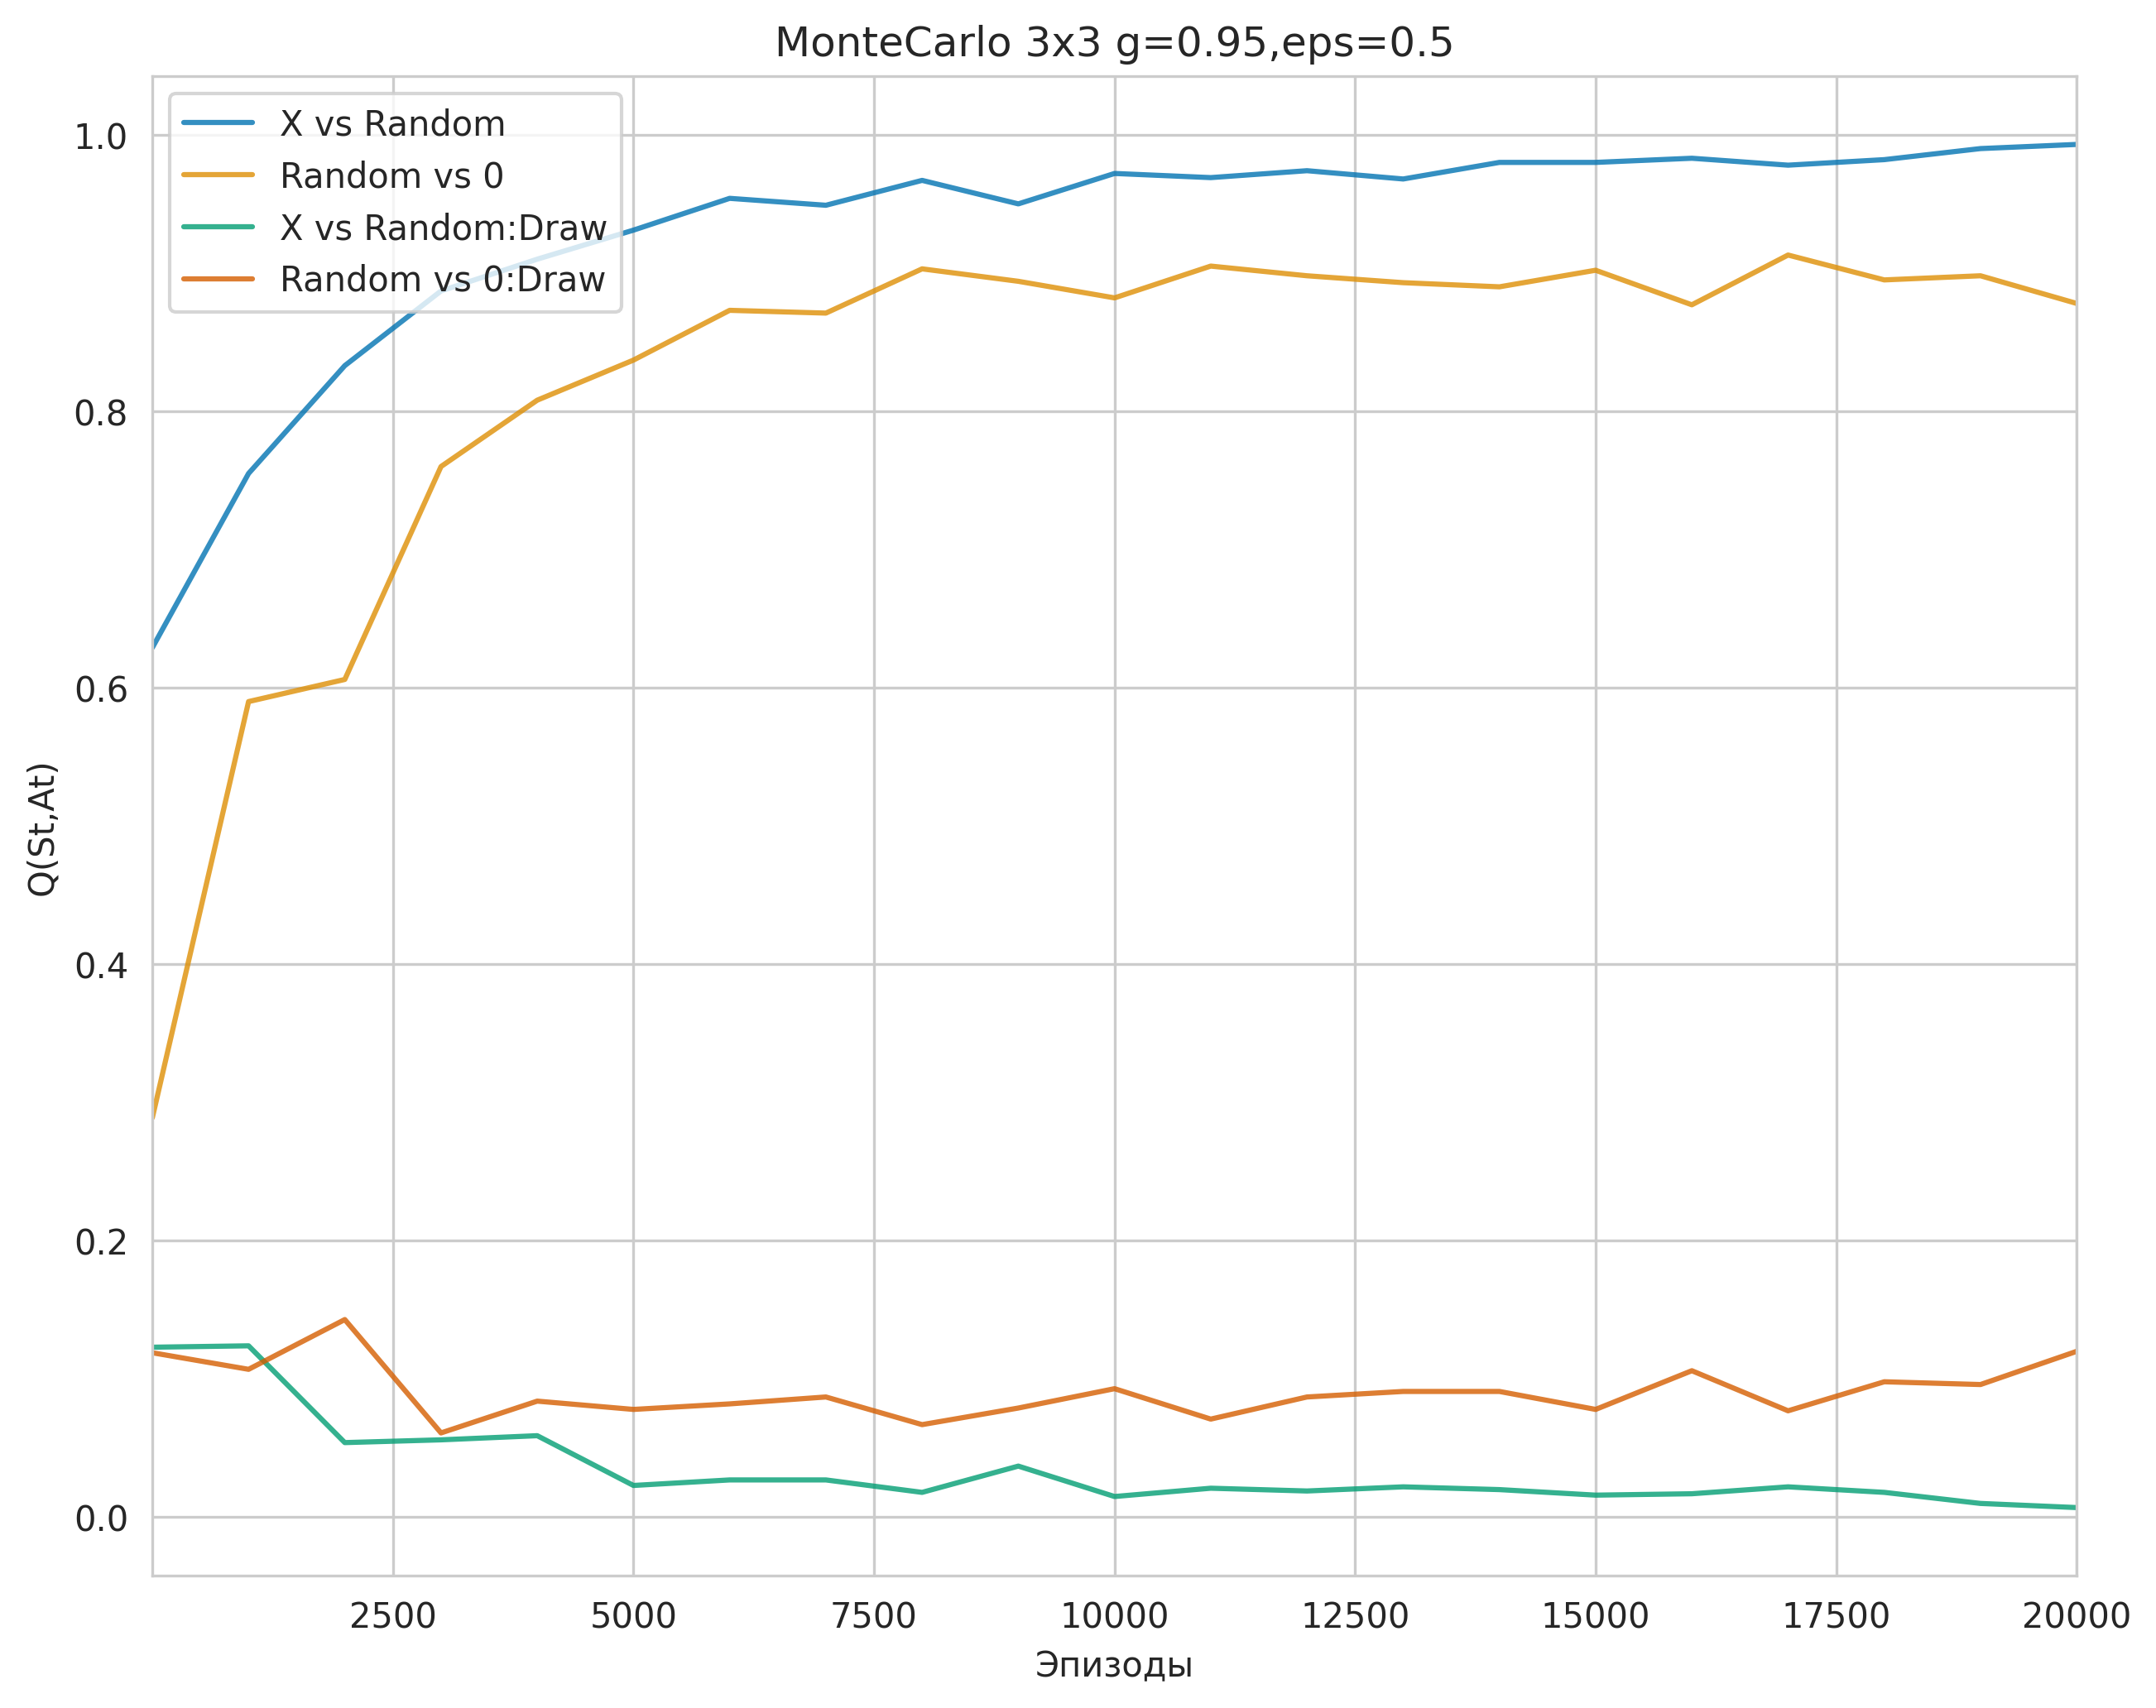

V(pi vs random)= {'X': 0.987, '0': 0.0, '-': 0.013, 'fail': 0.0, 'mean_step': 5.56}
V(random vs pi)= {'X': 0.009, '0': 0.876, '-': 0.115, 'fail': 0.0, 'mean_step': 6.606}
CPU times: user 34.1 s, sys: 1.69 s, total: 35.8 s
Wall time: 32.5 s


In [ ]:
%%time
total_episodes = 20000
n_print = 20
print_step = total_episodes//n_print

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
rewards = {}
gamma = 0.95
eps = 0.5
print("gamma=",gamma,end="  ")
algo = MonteCarloRl(env,RandomStrategy(),gamma,eps)
observer = RlObserver(env,print_step) #RandomStrategy(),
for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)
algo.close()

plot_observer(observer,f"MonteCarlo 3x3 g={gamma},eps={eps}",0)

reward = reward_by_games(env,pi,pi_random)
print("V(pi vs random)=",reward)
reward = reward_by_games(env,pi_random,pi)
print("V(random vs pi)=",reward)


## Q-Learning

In [ ]:
class QLearningRl(object):
    """ Q-Learning """
    
    def __init__(self,env,alpha=0.05,gamma=0.9,eps=0.1):
        self.env = env        
        self.alpha = alpha
        self.gamma = gamma        
        self.eps = eps        
        self.Q = {}
        self.pi = QStrategy(self.Q,self.eps)
        self.random_strategy = RandomStrategy()
    
    def close(self):
        self.env.close()
        
    def step(self):                        
        self.env.reset()                        
        
        actions = env.getEmptySpaces()
        st = env.getHash()
        _,action,at = self.random_strategy.select(env)        
        observation, reward, is_done, info = self.env.step(action)
        st = env.getHash()
        is_done = False
        while not is_done:
            actions = env.getEmptySpaces()           
            _,action,at = self.pi.select_eps(env)                            
            observation, reward, is_done, info = self.env.step(action)
            reward *= -self.env.curTurn
            stn = env.getHash()

            q_max = -self.pi.getMax(stn)
            q_value = self.pi.get(st,at)            
            self.pi.update(st,at,q_value + self.alpha*(reward+self.gamma*q_max-q_value))
            
            st = stn

        return self.Q,self.pi     

### 3x3

step= 0  step= 10000  step= 20000  step= 30000  step= 40000  step= 50000  step= 60000  step= 70000  step= 80000  step= 90000  step= 100000  step= 110000  step= 120000  step= 130000  step= 140000  step= 150000  step= 160000  step= 170000  step= 180000  step= 190000  step= 199999  

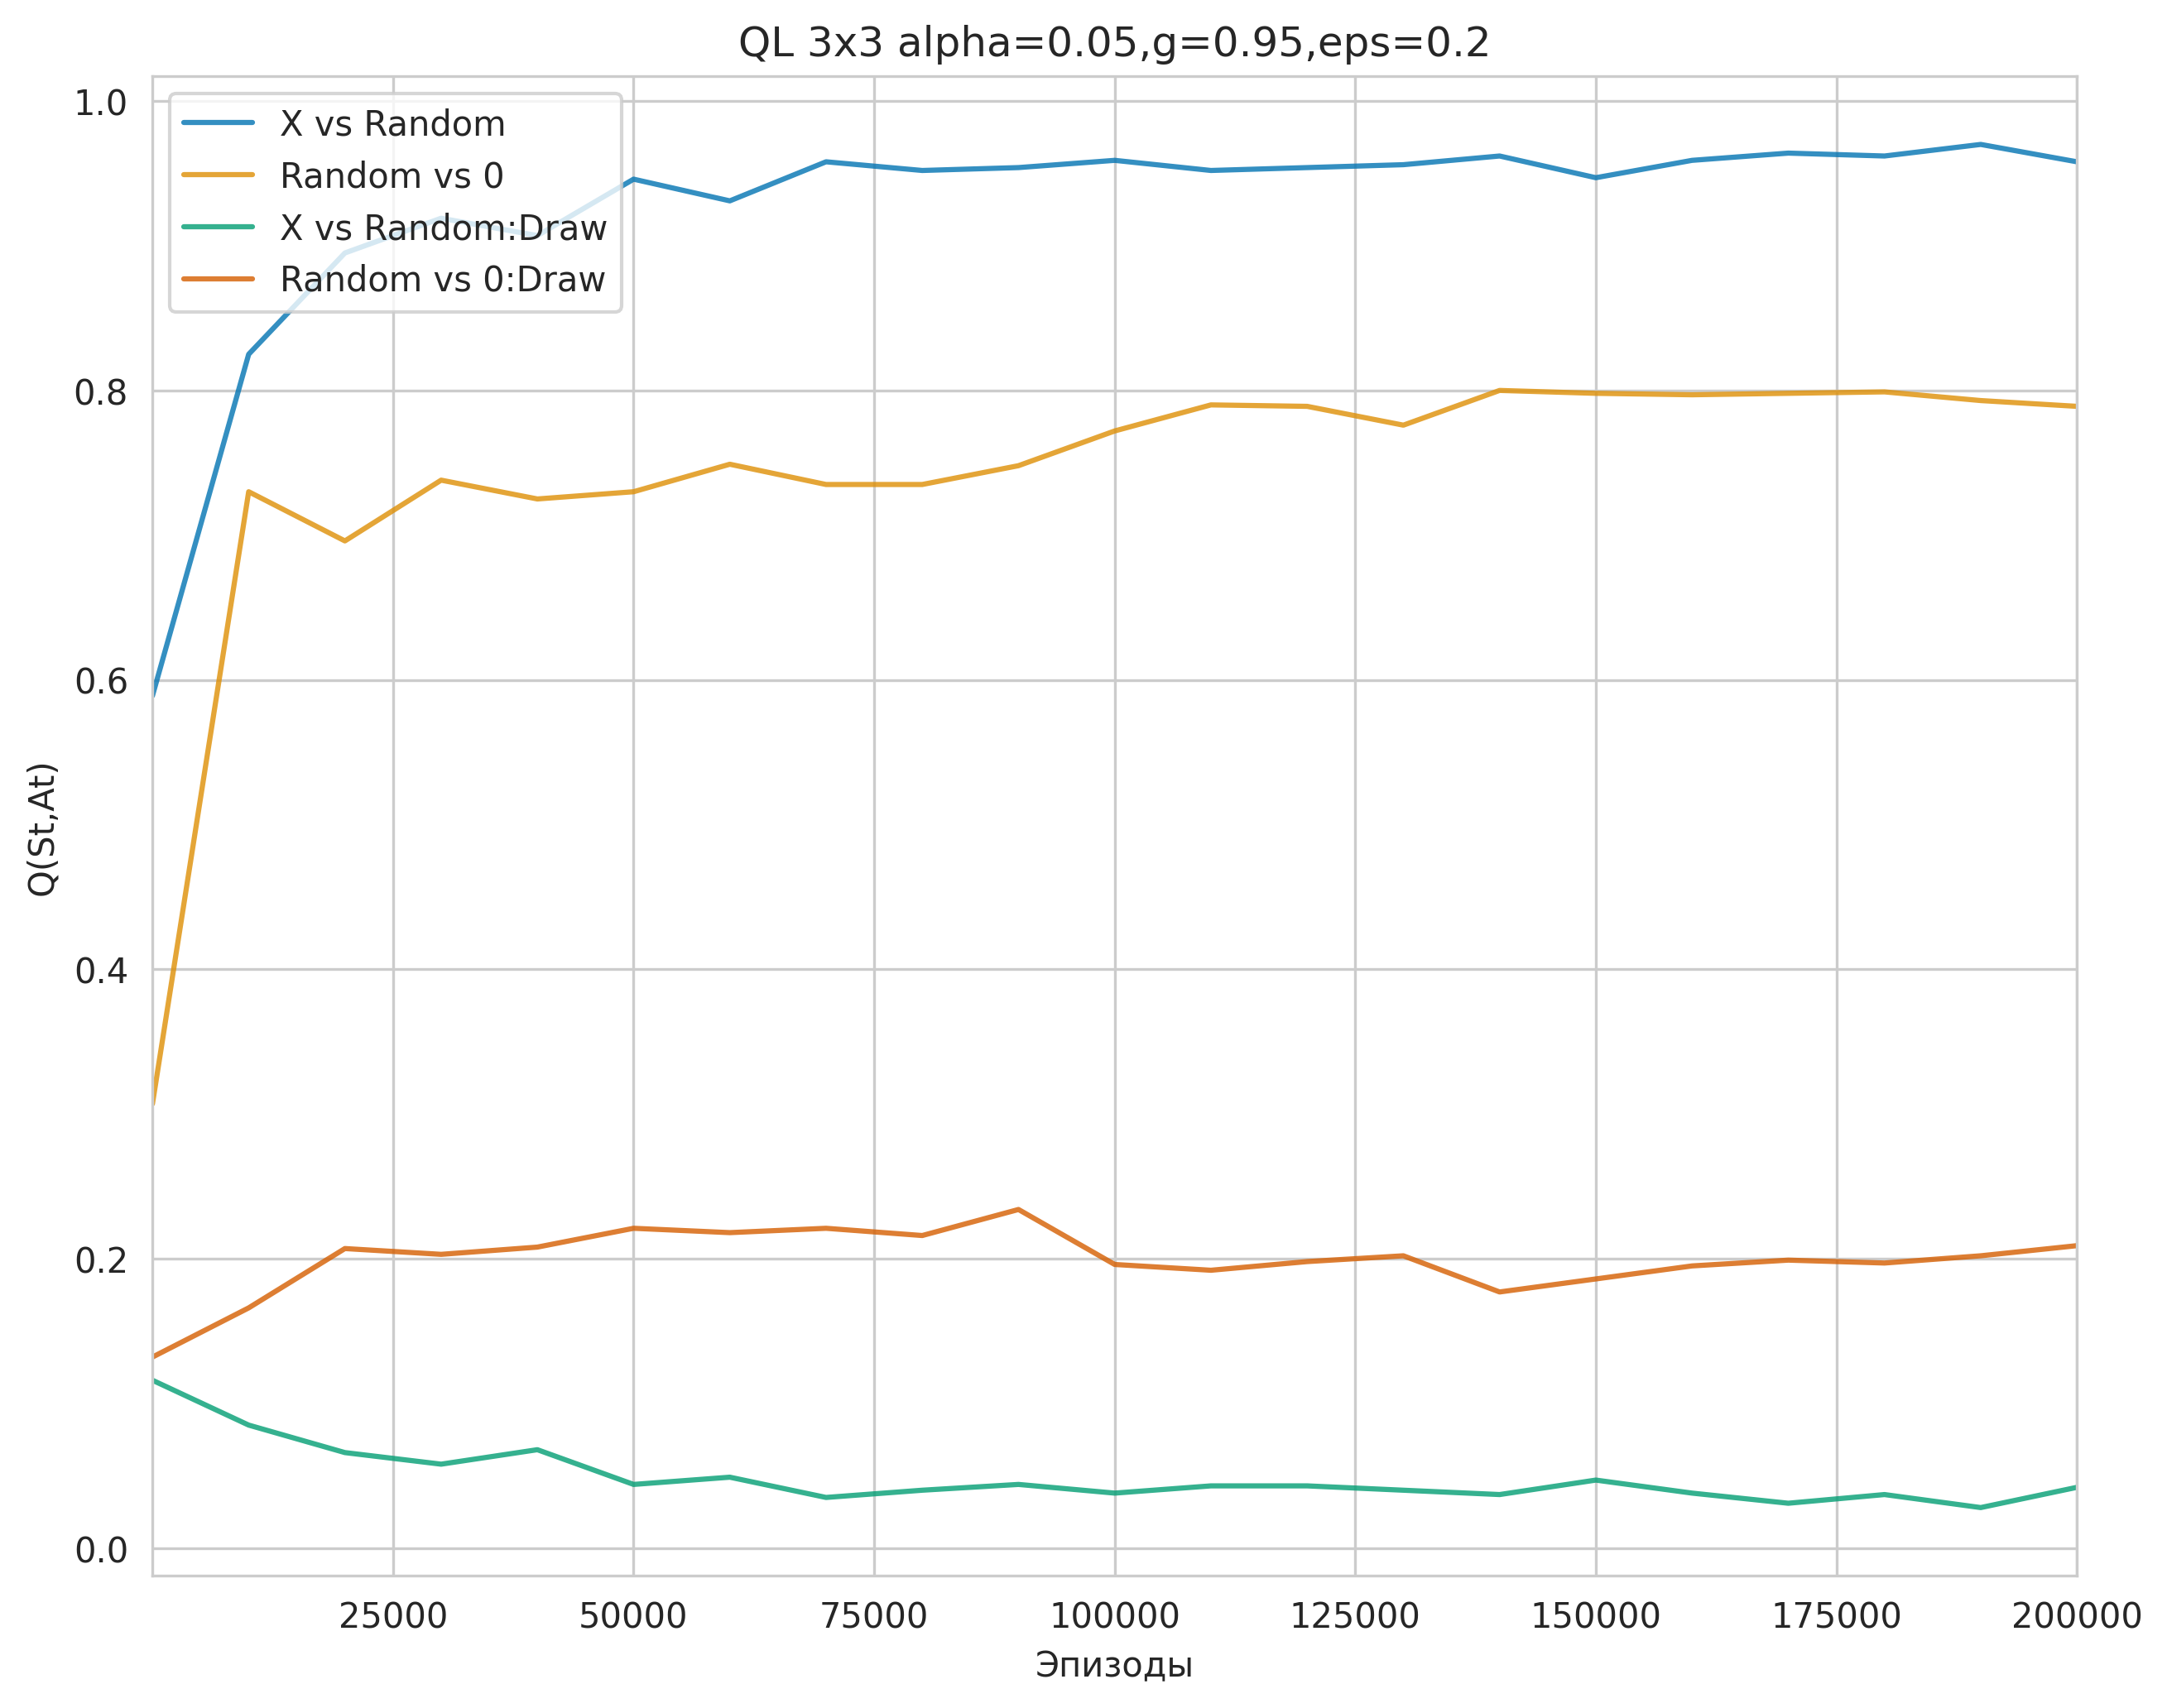

V(pi vs random)= {'X': 0.963, '0': 0.001, '-': 0.036, 'fail': 0.0, 'mean_step': 5.911}
V(random vs pi)= {'X': 0.004, '0': 0.801, '-': 0.195, 'fail': 0.0, 'mean_step': 7.097}
CPU times: user 2min 27s, sys: 1.26 s, total: 2min 29s
Wall time: 2min 26s


In [ ]:
%%time
total_episodes = 200000
n_print = 20
print_step = total_episodes//n_print

env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
rewards = {}
alpha = 0.05
gamma = 0.95
eps = 0.2

algo = QLearningRl(env,alpha,gamma,eps)
observer = RlObserver(env,print_step)
for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)
algo.close()

plot_observer(observer,f"QL 3x3 alpha={alpha},g={gamma},eps={eps}",0)

reward = reward_by_games(env,pi,pi_random)
print("V(pi vs random)=",reward)
reward = reward_by_games(env,pi_random,pi)
print("V(random vs pi)=",reward)

### 4x4

step= 0  step= 125000  step= 250000  step= 375000  step= 500000  step= 625000  step= 750000  step= 875000  step= 1000000  step= 1125000  step= 1250000  step= 1375000  step= 1500000  step= 1625000  step= 1750000  step= 1875000  step= 2000000  step= 2125000  step= 2250000  step= 2375000  step= 2499999  

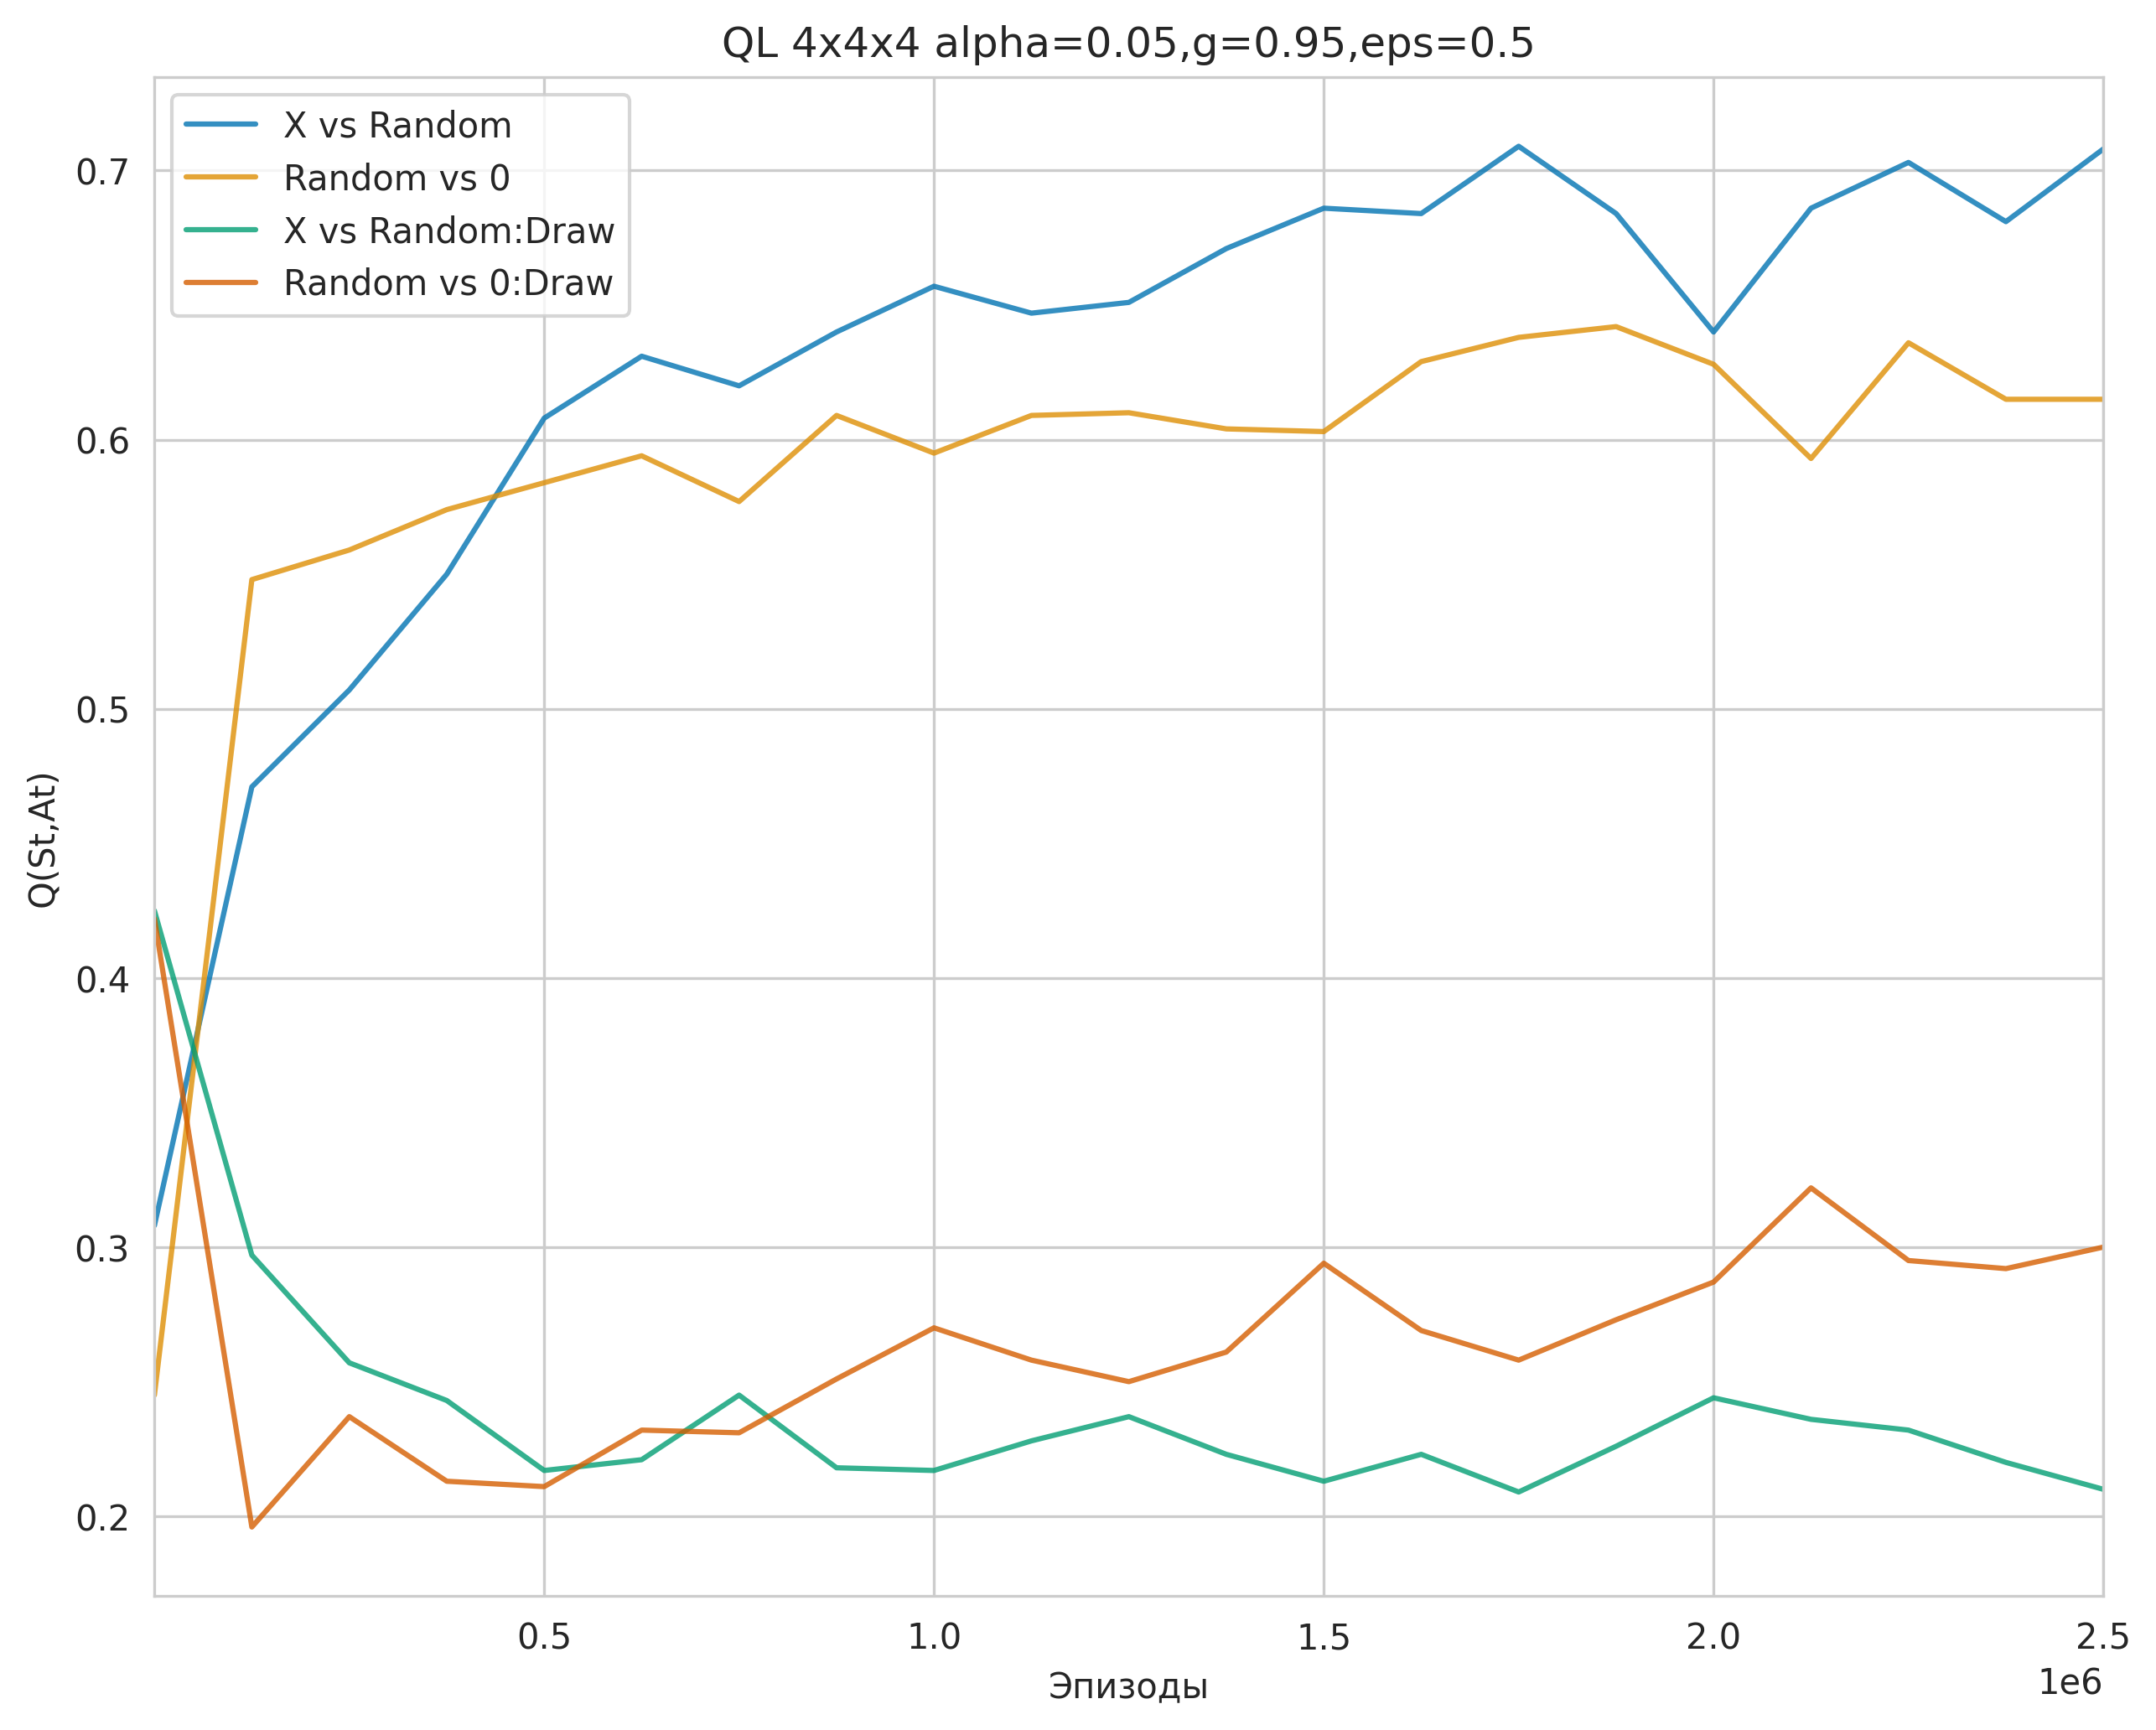

V(pi vs random)= {'X': 0.713, '0': 0.078, '-': 0.209, 'fail': 0.0, 'mean_step': 11.491}
V(random vs pi)= {'X': 0.062, '0': 0.634, '-': 0.304, 'fail': 0.0, 'mean_step': 11.97}
CPU times: user 1h 2min 45s, sys: 7.85 s, total: 1h 2min 53s
Wall time: 1h 2min 44s


In [ ]:
%%time
total_episodes = 2500000
n_print = 20
print_step = total_episodes//n_print

env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
rewards = {}
alpha = 0.05
gamma = 0.95
eps = 0.5

algo = QLearningRl(env,alpha,gamma,eps)
observer = RlObserver(env,print_step)
for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)
algo.close()

plot_observer(observer,f"QL 4x4х4 alpha={alpha},g={gamma},eps={eps}",0)

reward = reward_by_games(env,pi,pi_random)
print("V(pi vs random)=",reward)
reward = reward_by_games(env,pi_random,pi)
print("V(random vs pi)=",reward)

### 5x5

step= 0  step= 100000  step= 200000  step= 300000  step= 400000  step= 500000  step= 600000  step= 700000  step= 800000  step= 900000  step= 1000000  step= 1100000  step= 1200000  step= 1300000  step= 1400000  step= 1500000  step= 1600000  step= 1700000  step= 1800000  step= 1900000  step= 2000000  step= 2100000  step= 2200000  step= 2300000  step= 2400000  step= 2500000  step= 2600000  step= 2699999  

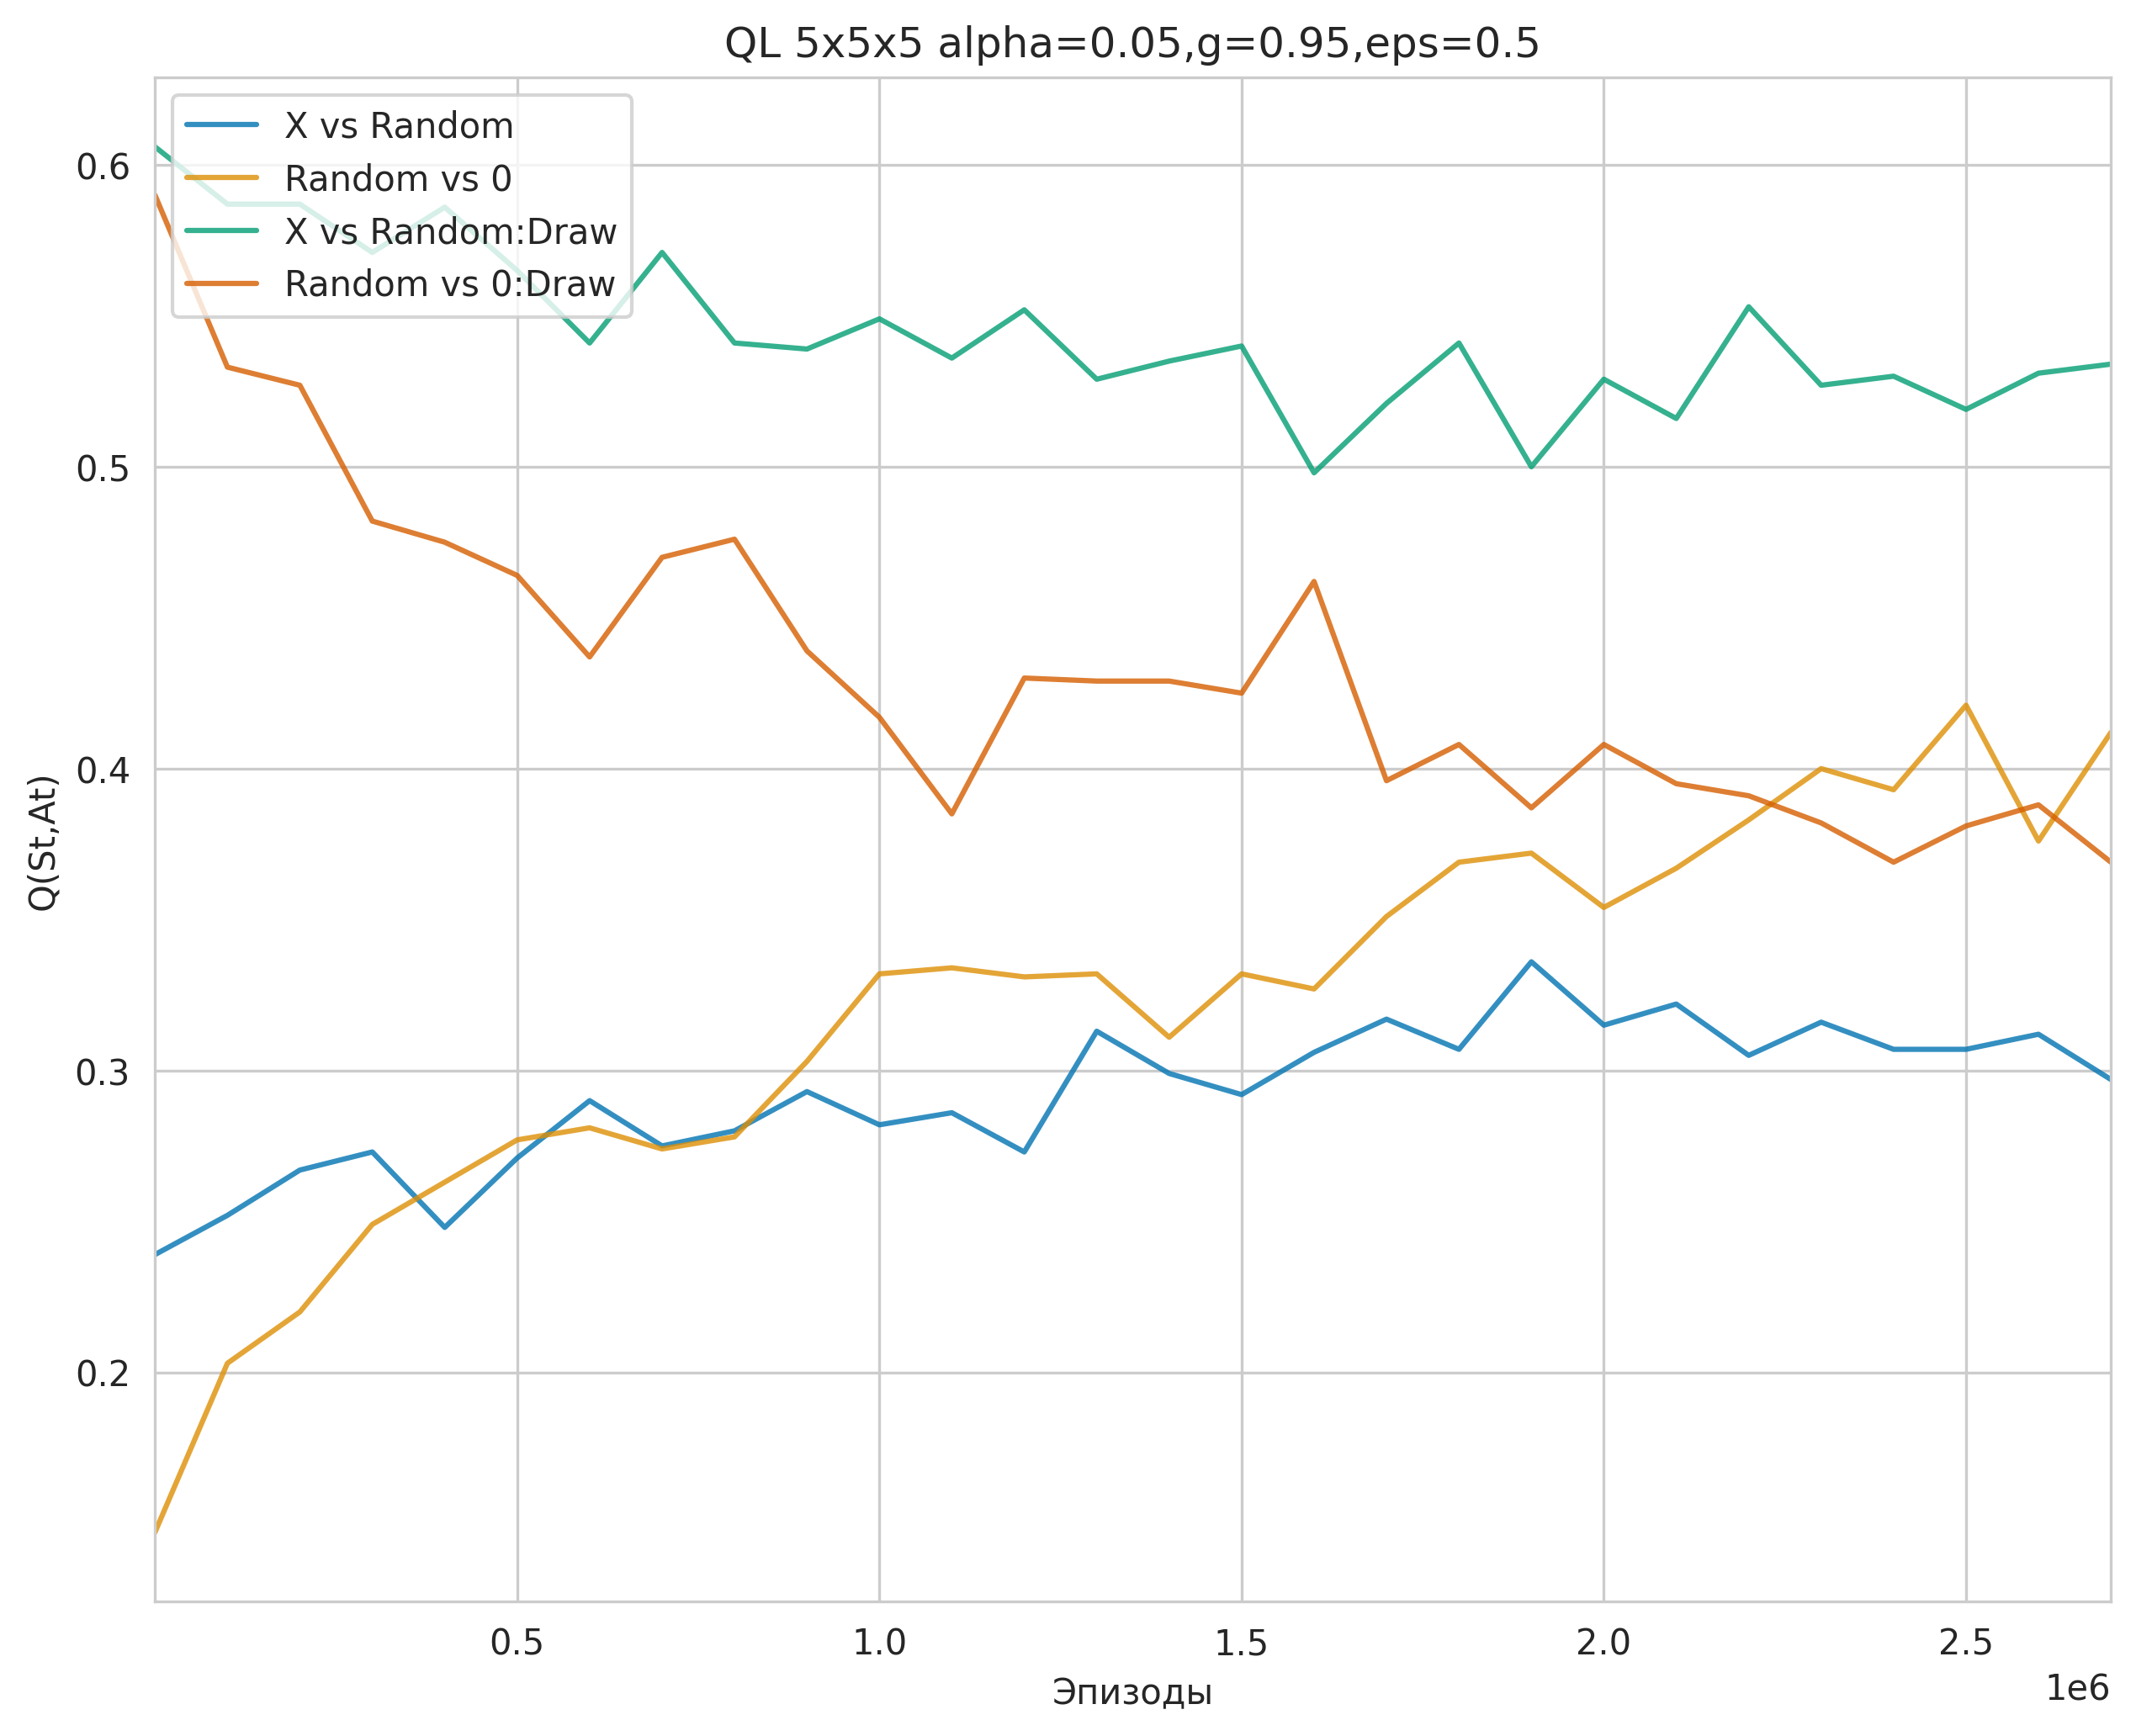

V(pi vs random)= {'X': 0.32, '0': 0.17, '-': 0.51, 'fail': 0.0, 'mean_step': 22.384}
V(random vs pi)= {'X': 0.224, '0': 0.397, '-': 0.379, 'fail': 0.0, 'mean_step': 19.935}
CPU times: user 2h 10min 40s, sys: 19.1 s, total: 2h 10min 59s
Wall time: 2h 11min 5s


In [ ]:
%%time
total_episodes = 2700000
n_print = 27
print_step = total_episodes//n_print

env = TicTacToe(n_rows=5, n_cols=5, n_win=5)
rewards = {}
alpha = 0.05
gamma = 0.95
eps = 0.5

algo = QLearningRl(env,alpha,gamma,eps)
observer = RlObserver(env,print_step) 
for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)
# algo.close()

plot_observer(observer,f"QL 5x5х5 alpha={alpha},g={gamma},eps={eps}",0)

reward = reward_by_games(env,pi,pi_random)
print("V(pi vs random)=",reward)
reward = reward_by_games(env,pi_random,pi)
print("V(random vs pi)=",reward)

step= 2800000  step= 2900000  step= 3000000  step= 3100000  step= 3200000  step= 3300000  step= 3400000  step= 3500000  step= 3600000  step= 3700000  step= 3800000  step= 3900000  step= 4000000  step= 4100000  step= 4200000  step= 4300000  step= 4400000  step= 4500000  step= 4600000  step= 4700000  step= 4800000  step= 4900000  step= 5000000  step= 5100000  step= 5200000  step= 5300000  step= 5400000  step= 5400000  

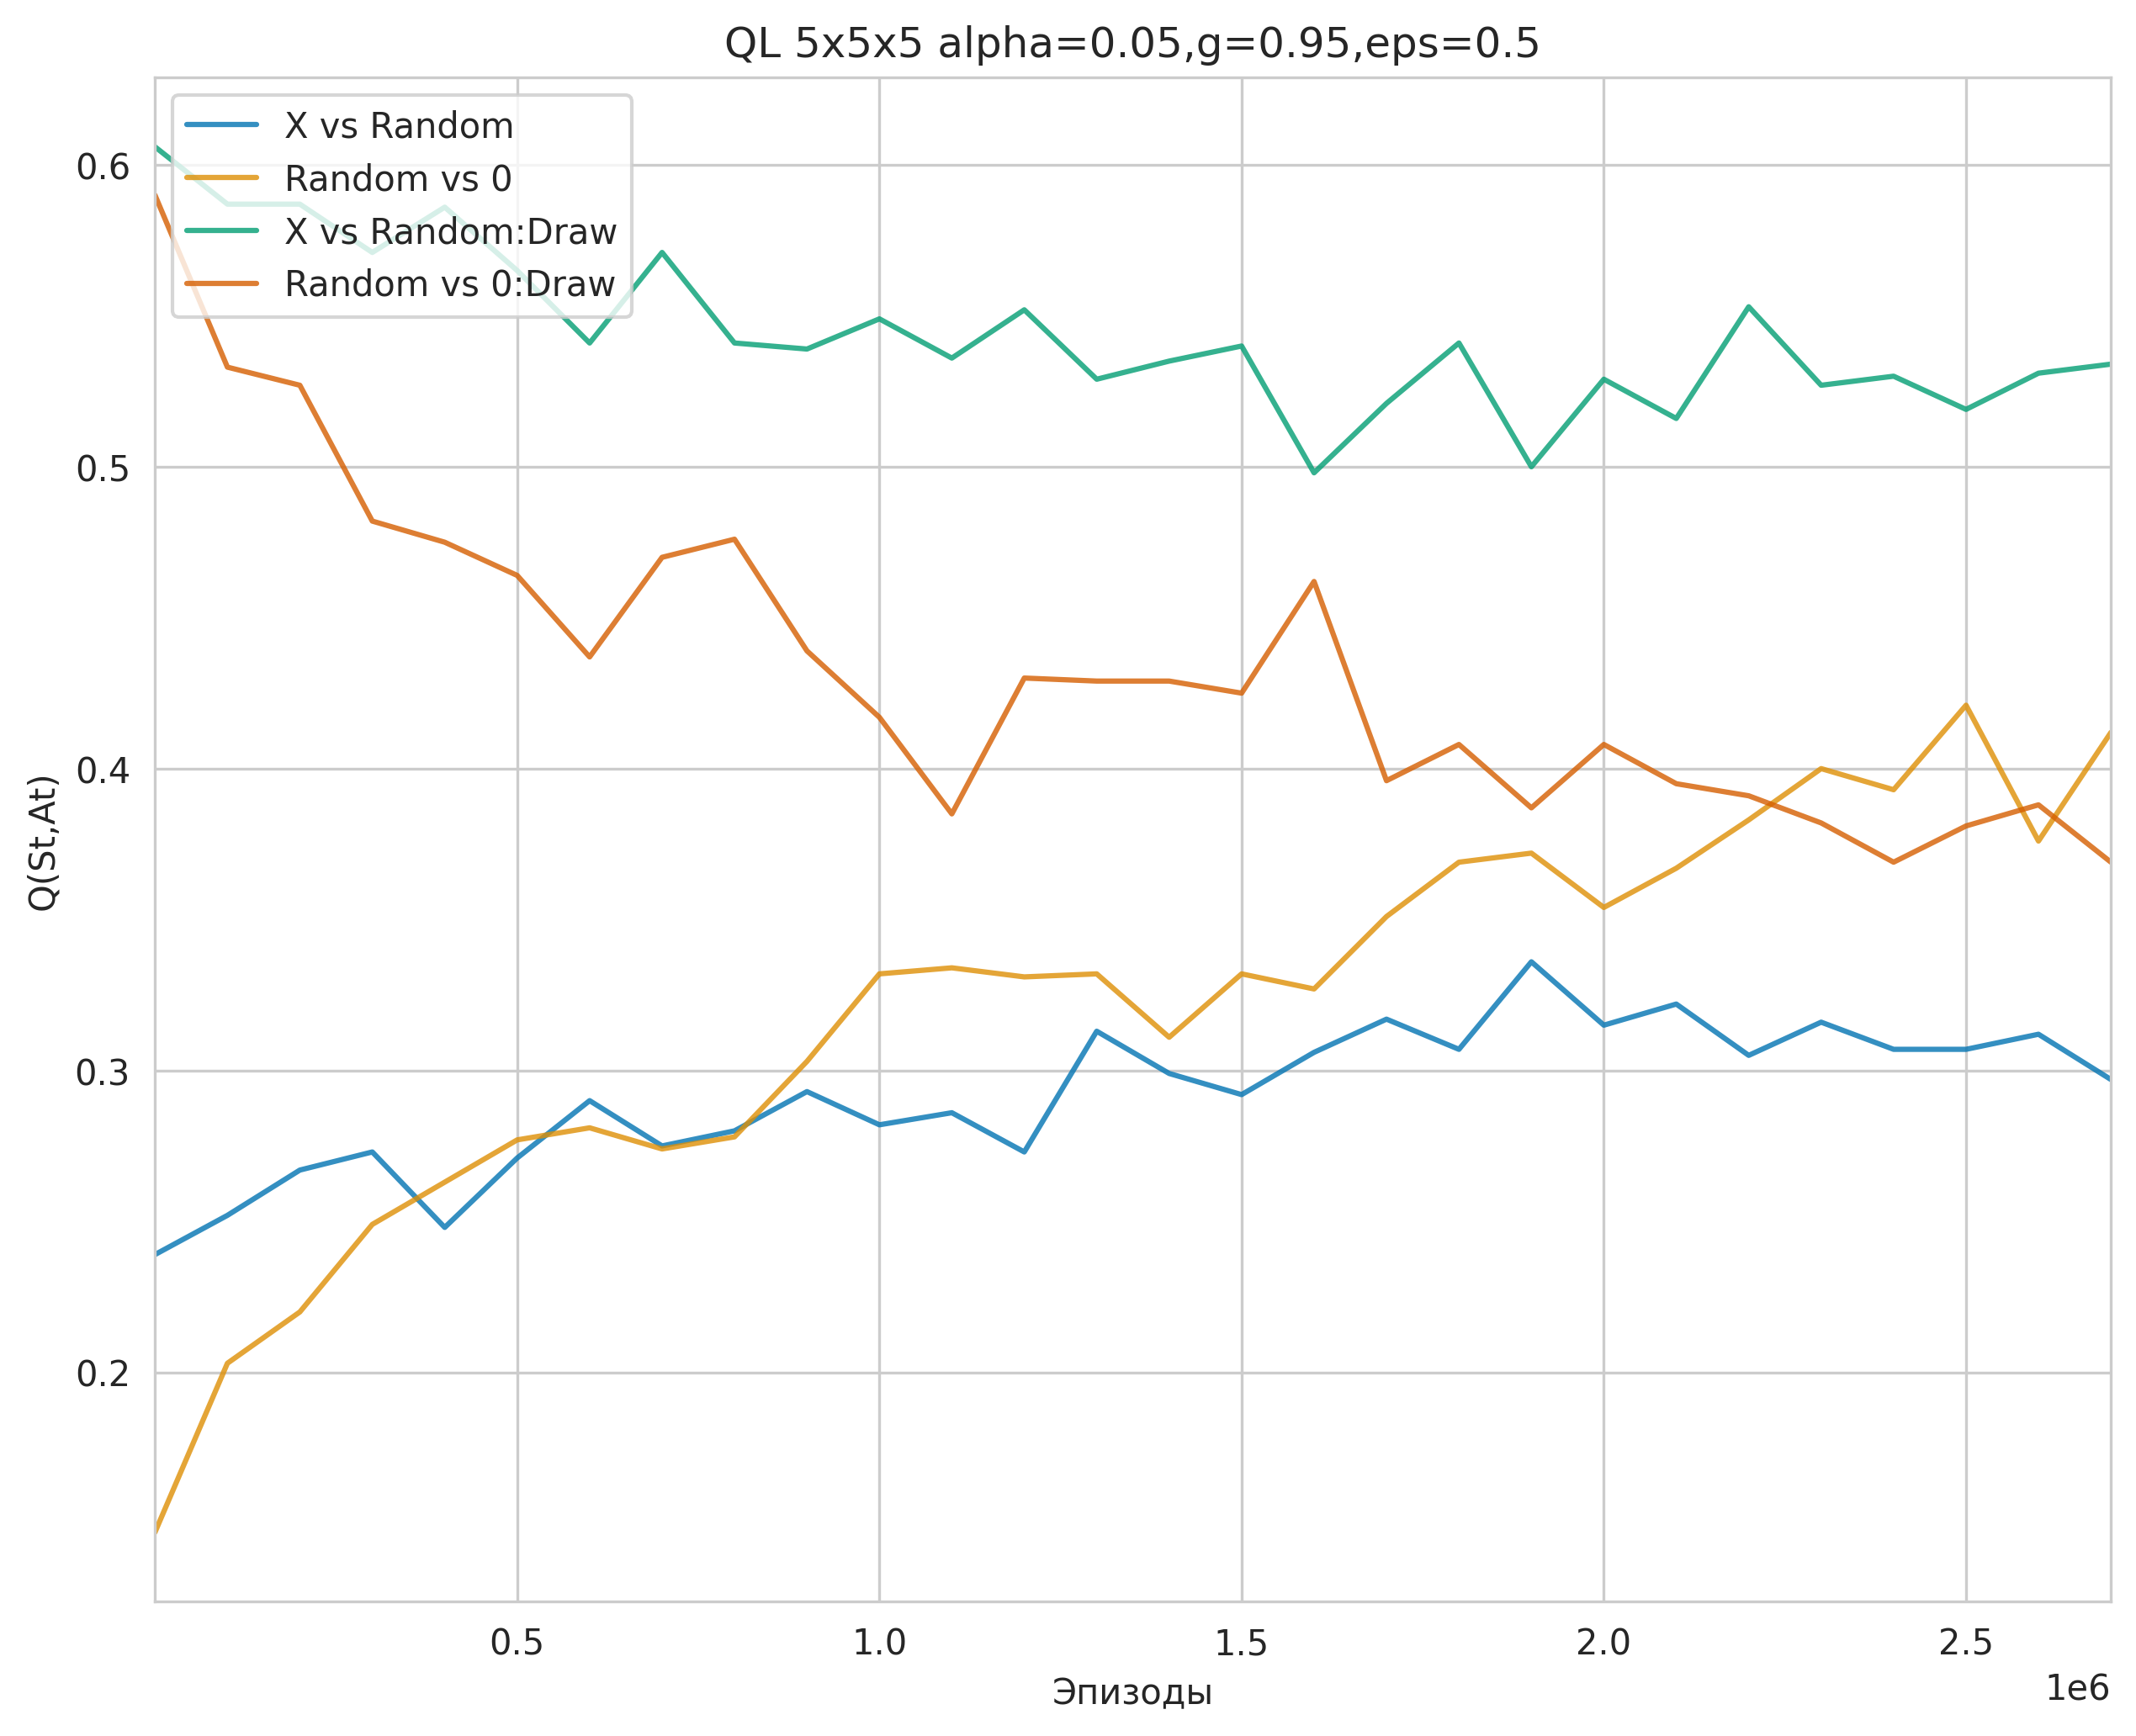

V(pi vs random)= {'X': 0.544, '0': 0.324, '-': 0.132, 'fail': 0.0, 'mean_step': 7.716}
V(random vs pi)= {'X': 0.588, '0': 0.283, '-': 0.129, 'fail': 0.0, 'mean_step': 7.681}


In [ ]:
for i in range(total_episodes+1,2*total_episodes+1):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)

plot_observer(observer,f"QL 5x5х5 alpha={alpha},g={gamma},eps={eps}",0)

reward = reward_by_games(env,pi,pi_random)
print("V(pi vs random)=",reward)
reward = reward_by_games(env,pi_random,pi)
print("V(random vs pi)=",reward)

# 2. Часть вторая: добавим нейронных сетей

## DQN

In [ ]:
class ModelStrategy(object):
    """ Стратегия - основе сети. 
    Возвращает случайное действие независимо от состояния. """
    def __init__(self, model):        
        self.model = model        
        
    def __str__(self):
        return "[model]"+str(model)
    
    def select(self,env):        
        board = env.board.flatten()

        board3 = np.concatenate([board==-1,board==0,board==1])
        state = torch.tensor([board3], dtype=torch.float32).to(device)
        res = self.model(state)
        a = res.data.cpu().detach().max(1)[1].view(1, 1)
        a = a.numpy()[0][0]
        return a,env.action_from_int(a),-1

        
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)


class TTTDQNTrainer():
    def __init__(self,env,modelX,model0,print_step = 1000,mem_size = 200000):
        env.reset()        
        self.env = env       
        self.modelX = modelX
        self.model0 = model0                
        self.print_step = print_step
        self.actions = env.getEmptySpaces()
        self.memoryX = ReplayMemory(mem_size)
        self.memory0 = ReplayMemory(mem_size)
        self.optimizerX = optim.AdamW(self.modelX.parameters(), 0.0001)
        self.optimizer0 = optim.AdamW(self.model0.parameters(), 0.0001)
        self.episode_stat = {"X:win":[],"X:draw":[],"X:fail":[],"0:win":[],"0:draw":[],"X:step":[]}
        self.steps = []
        self.gamma = 0.8
        self.batch_size = 512        
        self.eps_fix = 0.5        
#         self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 50000
#         self.num_step = 0

    def select_greedy_action(self, state, model):
        state = state.to(device)
        a = model(state).cpu().detach().data.max(1)[1].view(1, 1)        
        return a

    def select_action(self, state,model):
        sample = random.random()
#         self.num_step += 1
#         eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        eps_threshold = self.eps_fix
        if sample > eps_threshold:            
            return self.select_greedy_action(state, model)
        else:           
            b = torch.tensor([[np.random.randint(model.out_size)]], dtype=torch.int64)
            return b

    def getState(self):
        board = self.env.board.flatten()        
        res = np.concatenate([board==-1,board==0,board==1])
        return res
        
    def run_episode(self, e=0, do_learning=True):
        self.env.reset()        
        
        notFirst = False
        while True:            
            if self.env.curTurn==1: # ход Х                
                stateX = self.getState()
                state_tensorX = torch.tensor([stateX], dtype=torch.float32)
                with torch.no_grad():
                    actionX = self.select_action(state_tensorX,self.modelX)
                actX = self.actions[actionX.numpy()[0][0]]     
                observation, reward, done, _ = self.env.step(actX)
                
                next_state0 = self.getState()
                next_state_tensor0 = torch.tensor([next_state0], dtype=torch.float32)                            
                                
                if reward!=0:
                    next_state_tensorX = torch.tensor([stateX], dtype=torch.float32)            
                    transition = (state_tensorX, actionX, next_state_tensorX, torch.tensor([reward], dtype=torch.float32))
                    self.memoryX.store(transition)
                
                if notFirst and (reward==1 or reward==0):
                    transition = (state_tensor0, action0, next_state_tensor0, torch.tensor([-reward], dtype=torch.float32))
                    self.memory0.store(transition)                                    
                    
                if do_learning:
                    self.learn(self.modelX,self.memoryX,self.optimizerX,1)
                    
            else:        
                notFirst = True
                state0 = self.getState()
                state_tensor0 = torch.tensor([state0], dtype=torch.float32)
                with torch.no_grad():
                    action0 = self.select_action(state_tensor0,self.model0)
                act0 = self.actions[action0.numpy()[0][0]]     
                observation, reward, done, _ = self.env.step(act0)
                                                              
                next_stateX = self.getState()
                next_state_tensorX = torch.tensor([next_stateX], dtype=torch.float32)
            
                if reward!=0:
                    next_state_tensor0 = torch.tensor([state0], dtype=torch.float32)        
                    rew0 = -reward if reward==-1 else reward
                    transition = (state_tensor0, action0, next_state_tensor0, torch.tensor([rew0], dtype=torch.float32))
                    self.memory0.store(transition)
            
                if reward==-1 or reward==0:
                    transition = (state_tensorX, actionX, next_state_tensorX, torch.tensor([reward], dtype=torch.float32))
                    self.memoryX.store(transition)                                    
                    
                if do_learning:
                    self.learn(self.model0,self.memory0,self.optimizer0,1)
                    
            if done:
                break
            
        if e%self.print_step==0:
            self.modelX.eval()
            # self.model.cpu()          
            piX = ModelStrategy(self.modelX)
            rX = reward_by_games(self.env,piX,pi_random)
            self.episode_stat["X:win"].append(rX["X"])
            self.episode_stat["X:draw"].append(rX["-"])
            self.episode_stat["X:fail"].append(rX["fail"])
            self.episode_stat["X:step"].append(rX["mean_step"])

            pi0 = ModelStrategy(self.model0)
            r0 = reward_by_games(self.env,pi_random,pi0)
            self.episode_stat["0:win"].append(r0["0"])
            self.episode_stat["0:draw"].append(r0["-"])                                                                            
            print(f"\t{e}:",rX,r0)
            self.steps.append(e)
            self.modelX.train()

    def learn(self,model,memory,optimizer,n=1):
        if len(memory) < self.batch_size:
            return

        for i in range(n):
        # берём мини-батч из памяти
            transitions = memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

            batch_state = Variable(torch.cat(batch_state)).to(device)
            batch_action = Variable(torch.cat(batch_action)).to(device)
            batch_reward = Variable(torch.cat(batch_reward)).to(device)
            batch_next_state = Variable(torch.cat(batch_next_state)).to(device)

            # считаем значения функции Q
            Q = model(batch_state).gather(1, batch_action).reshape([self.batch_size])

            # оцениваем ожидаемые значения после этого действия
            Qmax = model(batch_next_state).detach().max(1)[0]

            Qnext = batch_reward + (self.gamma * Qmax)

            # и хотим, чтобы Q было похоже на Qnext -- это и есть суть Q-обучения
            loss = F.smooth_l1_loss(Q, Qnext)

            optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            
        

In [ ]:
class ConvNetwork_3x3(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.in_size = 3*env.n_rows*env.n_cols
        self.out_size = env.n_rows*env.n_cols               
        sz_c1 = 32         
        self.hidden = (self.n_rows-(2-1))*(self.n_cols-(2-1))*sz_c1        
        self.c1 = nn.Conv2d(3,sz_c1,(2,2))        
        self.norm = nn.LayerNorm(self.hidden)                
        self.l1 = nn.Linear(self.hidden, self.hidden)
        self.l2 = nn.Linear(self.hidden, self.out_size)        

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)
        x = x.reshape(bs,-1)        
        x = self.norm(x)        
        x = torch.relu(x)
        x = self.l1(x)    
        x = torch.relu(x)
        x = self.l2(x)            
        return x

class ConvNetwork_4x4(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.in_size = 3*env.n_rows*env.n_cols
        self.out_size = env.n_rows*env.n_cols
        sz_c1 = 16        
        self.hidden1 = 128
        self.hidden2 = 64
        self.c1 = nn.Conv2d(3,sz_c1,(3,3))        
        self.c2 = nn.Conv2d(sz_c1,self.hidden1,(2,2))
        self.norm = nn.LayerNorm(self.hidden1)                        
        self.l1 = nn.Linear(self.hidden1, self.hidden2)
        self.l2 = nn.Linear(self.hidden2, self.out_size)        

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)        
        x = torch.relu(x)
        x = self.c2(x)        
        x = x.reshape(bs,-1)                
        x = self.norm(x)  
        x = torch.relu(x)
        x = self.l1(x)        
        x = torch.relu(x)
        x  = self.l2(x)                        
        return x

class ConvNetwork_5x5(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.out_size = env.n_rows*env.n_cols
        sz_c1 = 16
        self.hidden1 = 192
        self.hidden2 = 128
        self.c1 = nn.Conv2d(3,sz_c1,(3,3))                 
        self.c2 = nn.Conv2d(sz_c1,self.hidden1,(3,3))  
        self.norm = nn.LayerNorm(self.hidden1)                        
        self.l1 = nn.Linear(self.hidden1, self.hidden2)
        self.l2 = nn.Linear(self.hidden2, self.out_size)        

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)      
        x = torch.relu(x)
        x = self.c2(x)        
        x = x.reshape(bs,-1)                        
        x = self.norm(x)                
        x = torch.relu(x)
        x = self.l1(x)
        x = torch.relu(x)
        x = torch.relu(x)
        x  = self.l2(x) 
        return x        

### 3x3

ConvNetwork_3x3(
  (c1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=9, bias=True)
)
ConvNetwork_3x3(
  (c1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=9, bias=True)
)
18:00:57.968864	Starting training for 10000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.29} {'X': 0.009, '0': 0.0, '-': 0.0, 'fail': 0.991, 'mean_step': 3.963}
	1000: {'X': 0.766, '0': 0.121, '-': 0.113, 'fail': 0.0, 'mean_step': 6.817} {'X': 0.469, '0': 0.399, '-': 0.132, 'fail': 0.0, 'mean_step': 7.623}
	2000: {'X': 0.954, '0': 0.009, '-': 0.037, 'fail': 0.0, 'mean_step': 5.571} {'X': 0.379, '0': 0.572, '-': 0.049, 'fail': 0.0, 'mean_step': 7.

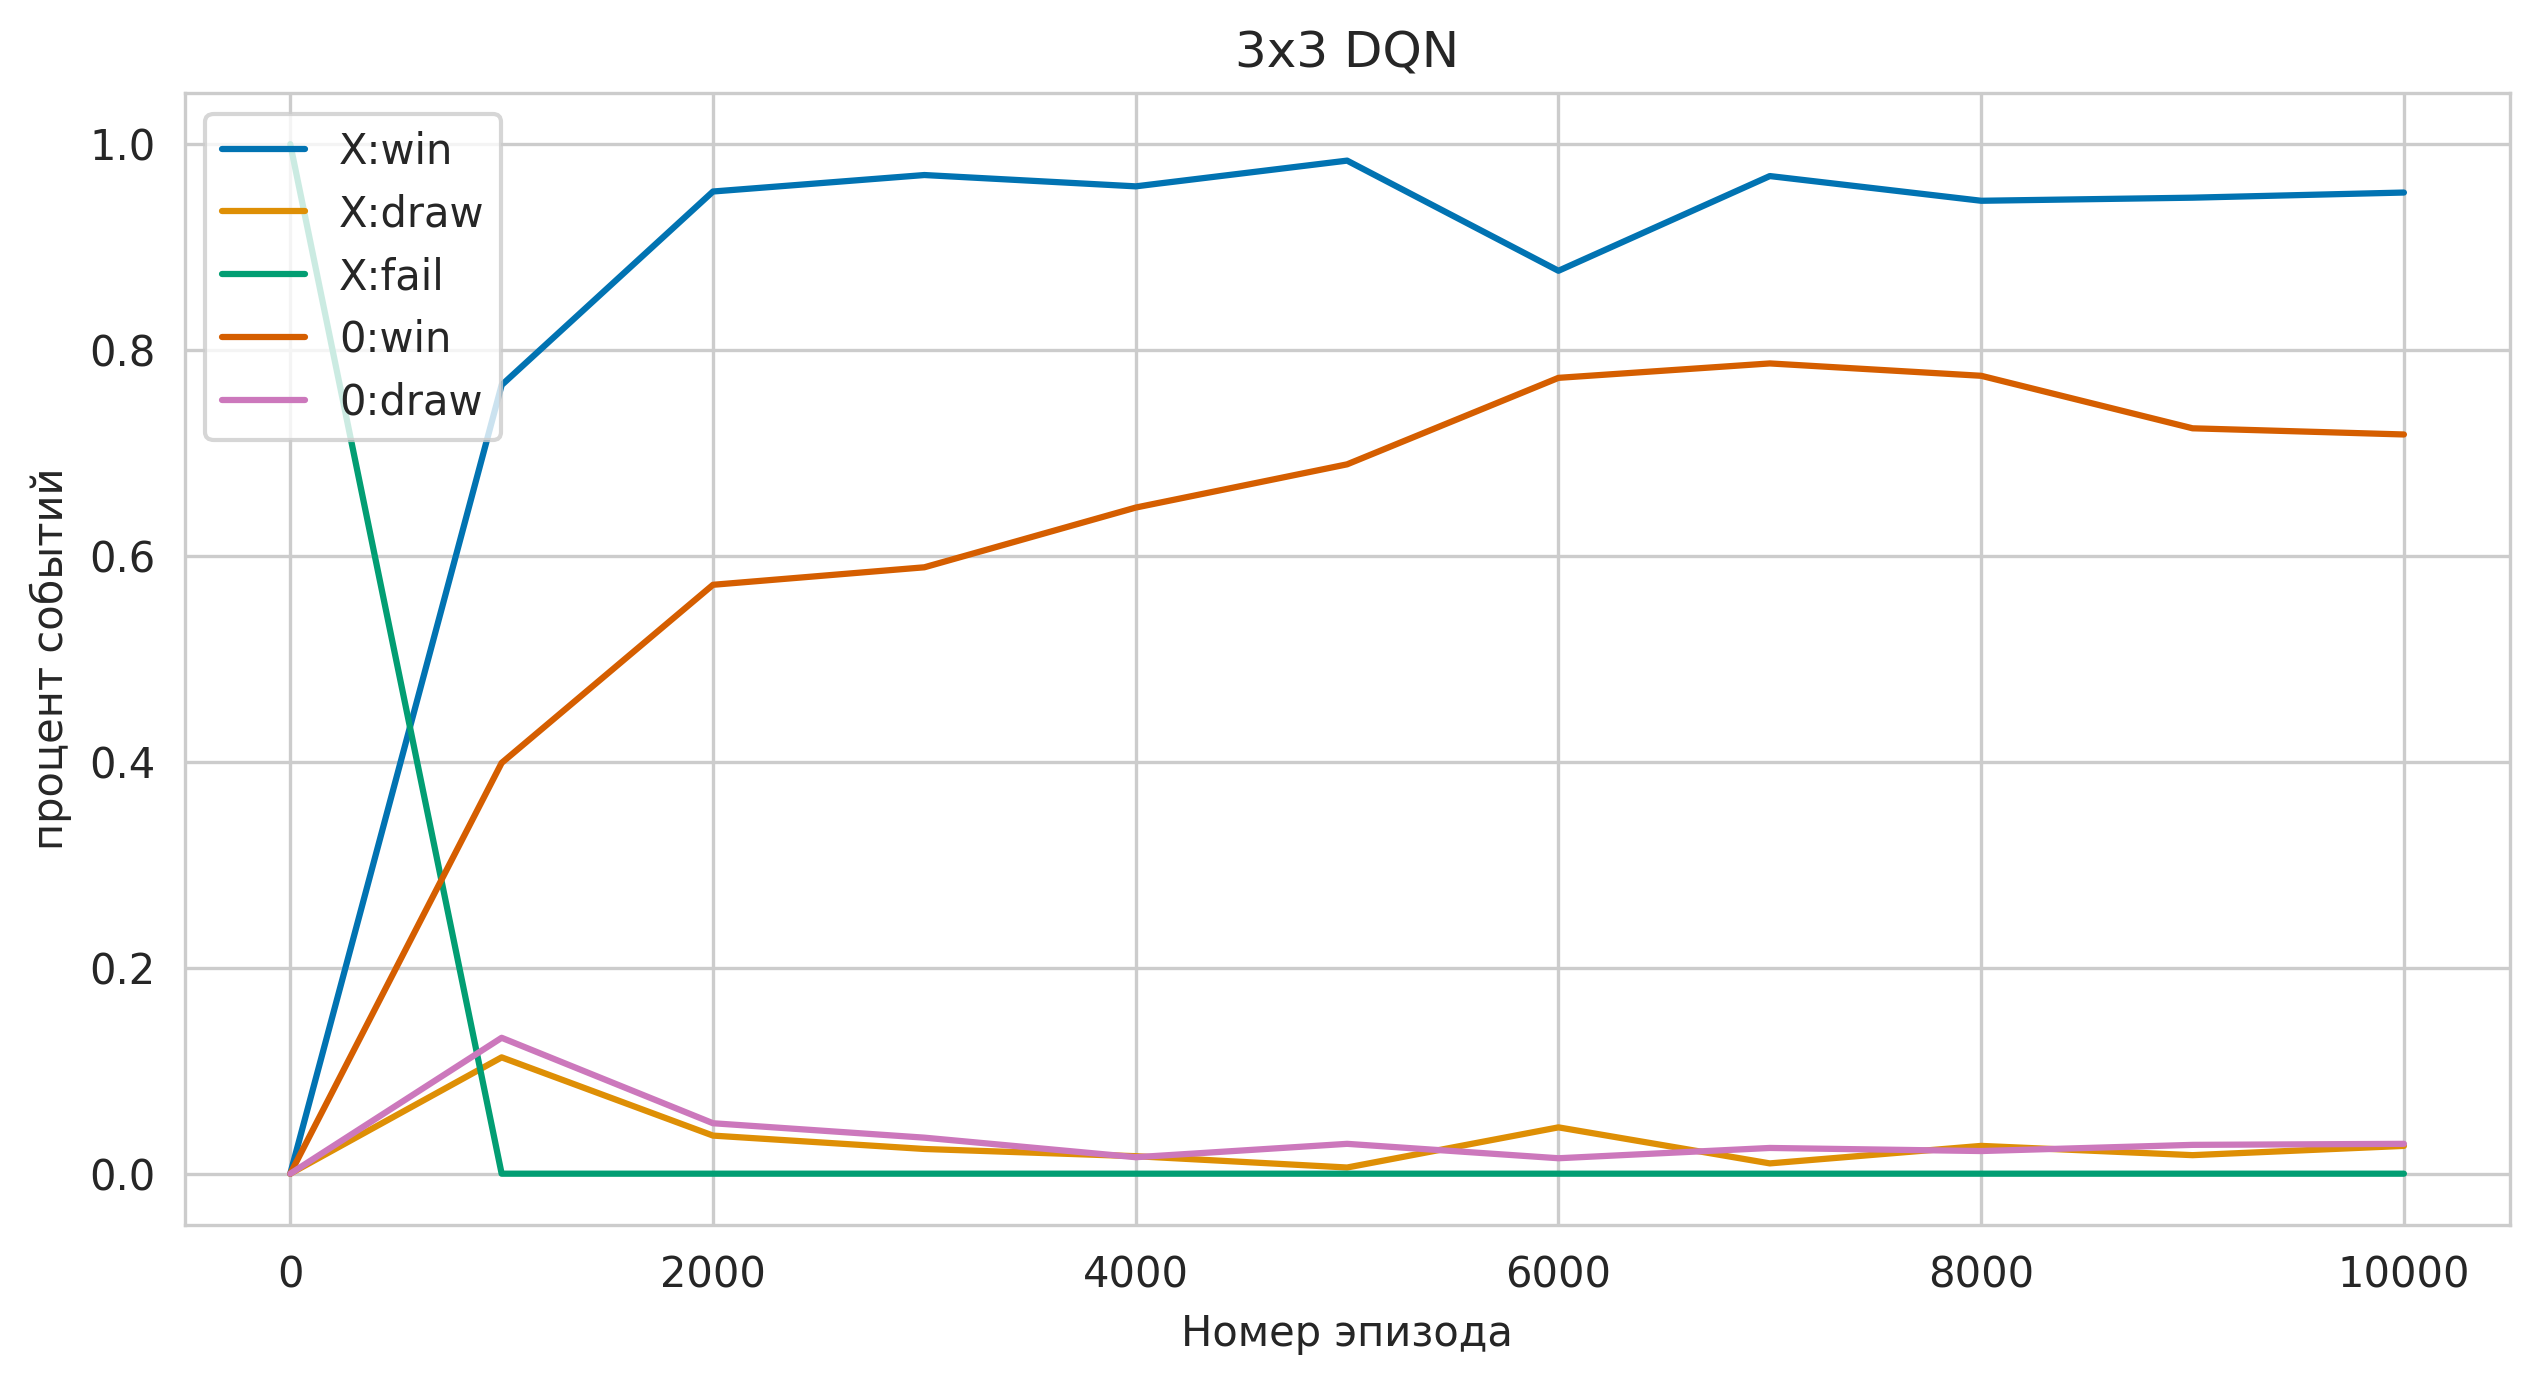

In [ ]:
%%time
env = TicTacToe(3,3,3)
modelX = ConvNetwork_3x3(env).to(device)        
model0 = ConvNetwork_3x3(env).to(device)        
dqn = TTTDQNTrainer(env,modelX,model0)
print(dqn.modelX)
print(dqn.model0)
n = 10000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("3x3 DQN",dqn.steps,dqn.episode_stat,["X:step"])

### 4x4

ConvNetwork_4x4(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=16, bias=True)
)
ConvNetwork_4x4(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=16, bias=True)
)
18:15:40.235571	Starting training for 100000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.664} {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.856}
	5000: {'X': 0.601, '0': 0.172, '-': 0.227, 'fail': 0.0, 'mean_step': 12.657} {'X': 0.262, '0': 0.355, '-': 0.382, 'fail': 0.001, 'mean_step': 14.218}
	10000: {'X': 0.725, '0'

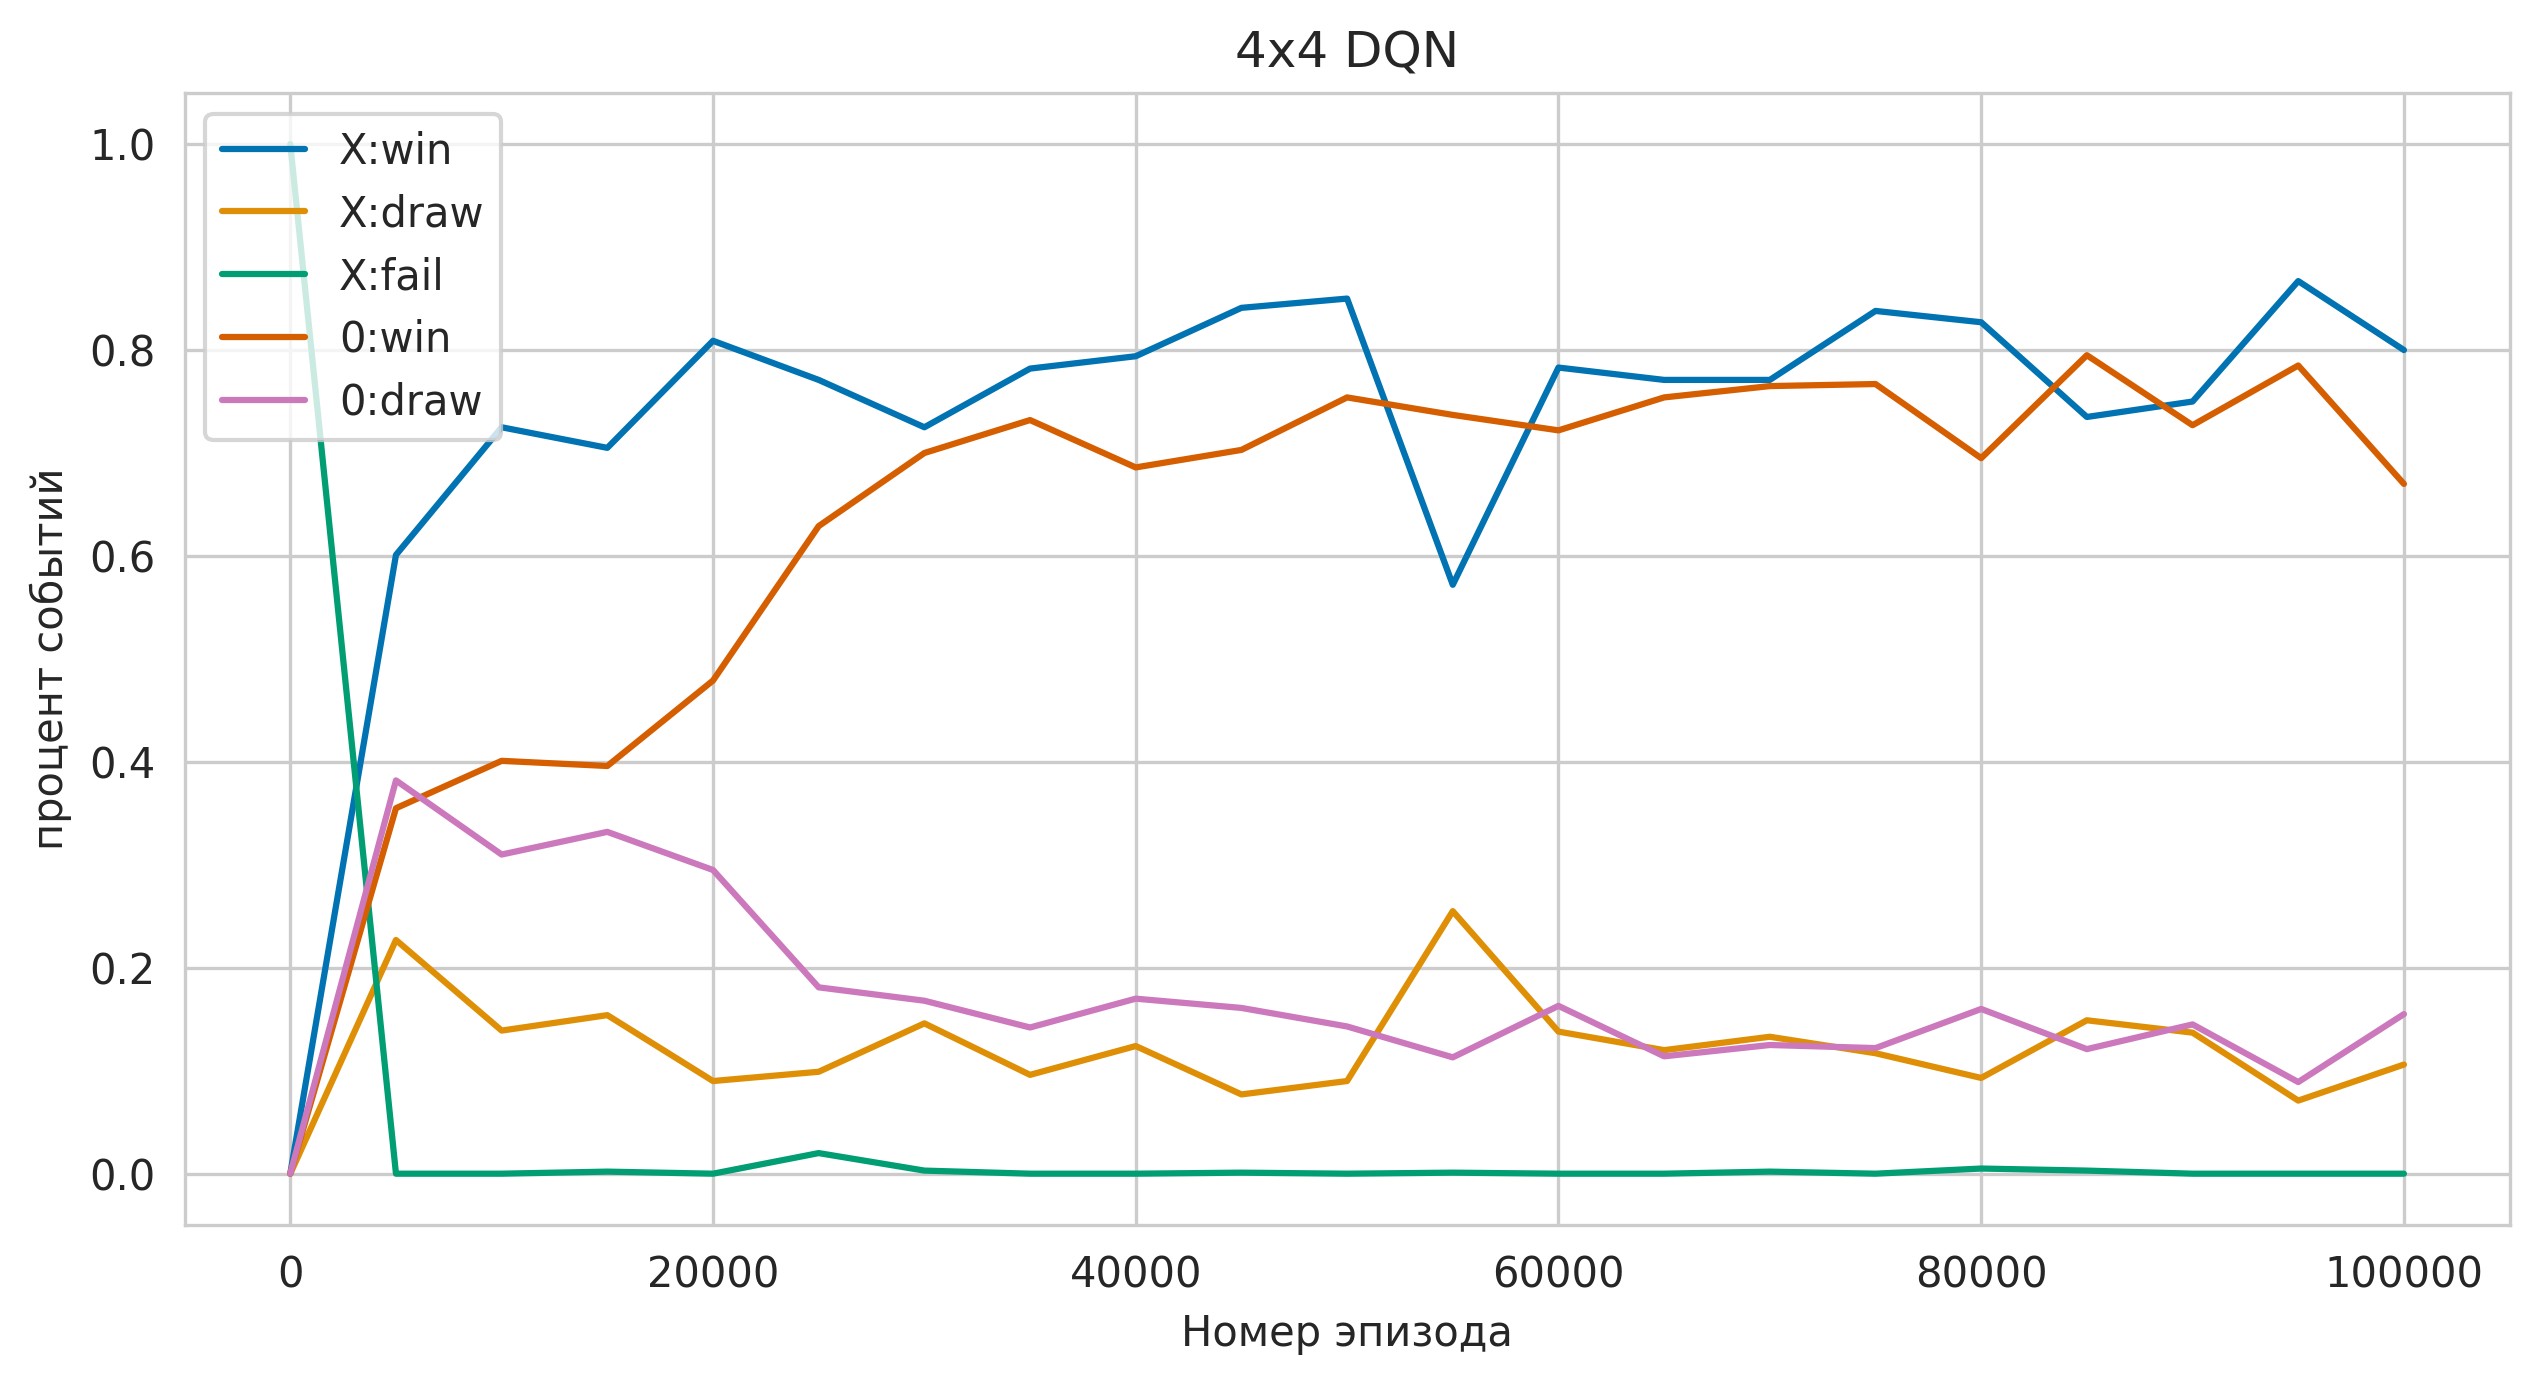

In [ ]:
%%time
env = TicTacToe(4,4,4)
modelX = ConvNetwork_4x4(env).to(device)        
model0 = ConvNetwork_4x4(env).to(device)        
dqn = TTTDQNTrainer(env,modelX,model0,print_step=5000)
print(dqn.modelX)
print(dqn.model0)
n = 100000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("4x4 DQN",dqn.steps,dqn.episode_stat,["X:step"])

### 5x5

ConvNetwork_5x5(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 192, kernel_size=(3, 3), stride=(1, 1))
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=192, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=25, bias=True)
)
ConvNetwork_5x5(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 192, kernel_size=(3, 3), stride=(1, 1))
  (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=192, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=25, bias=True)
)
02:25:18.488532	Starting training for 300000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 6.138} {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 4.42}
	10000: {'X': 0.319, '0': 0.173, '-': 0.497, 'fail': 0.011, 'mean_step': 23.363} {'X': 0.237, '0': 0.154, '-': 0.609, 'fail': 0.0, 'mean_step': 23.712}
	20000: {'X': 0.289,

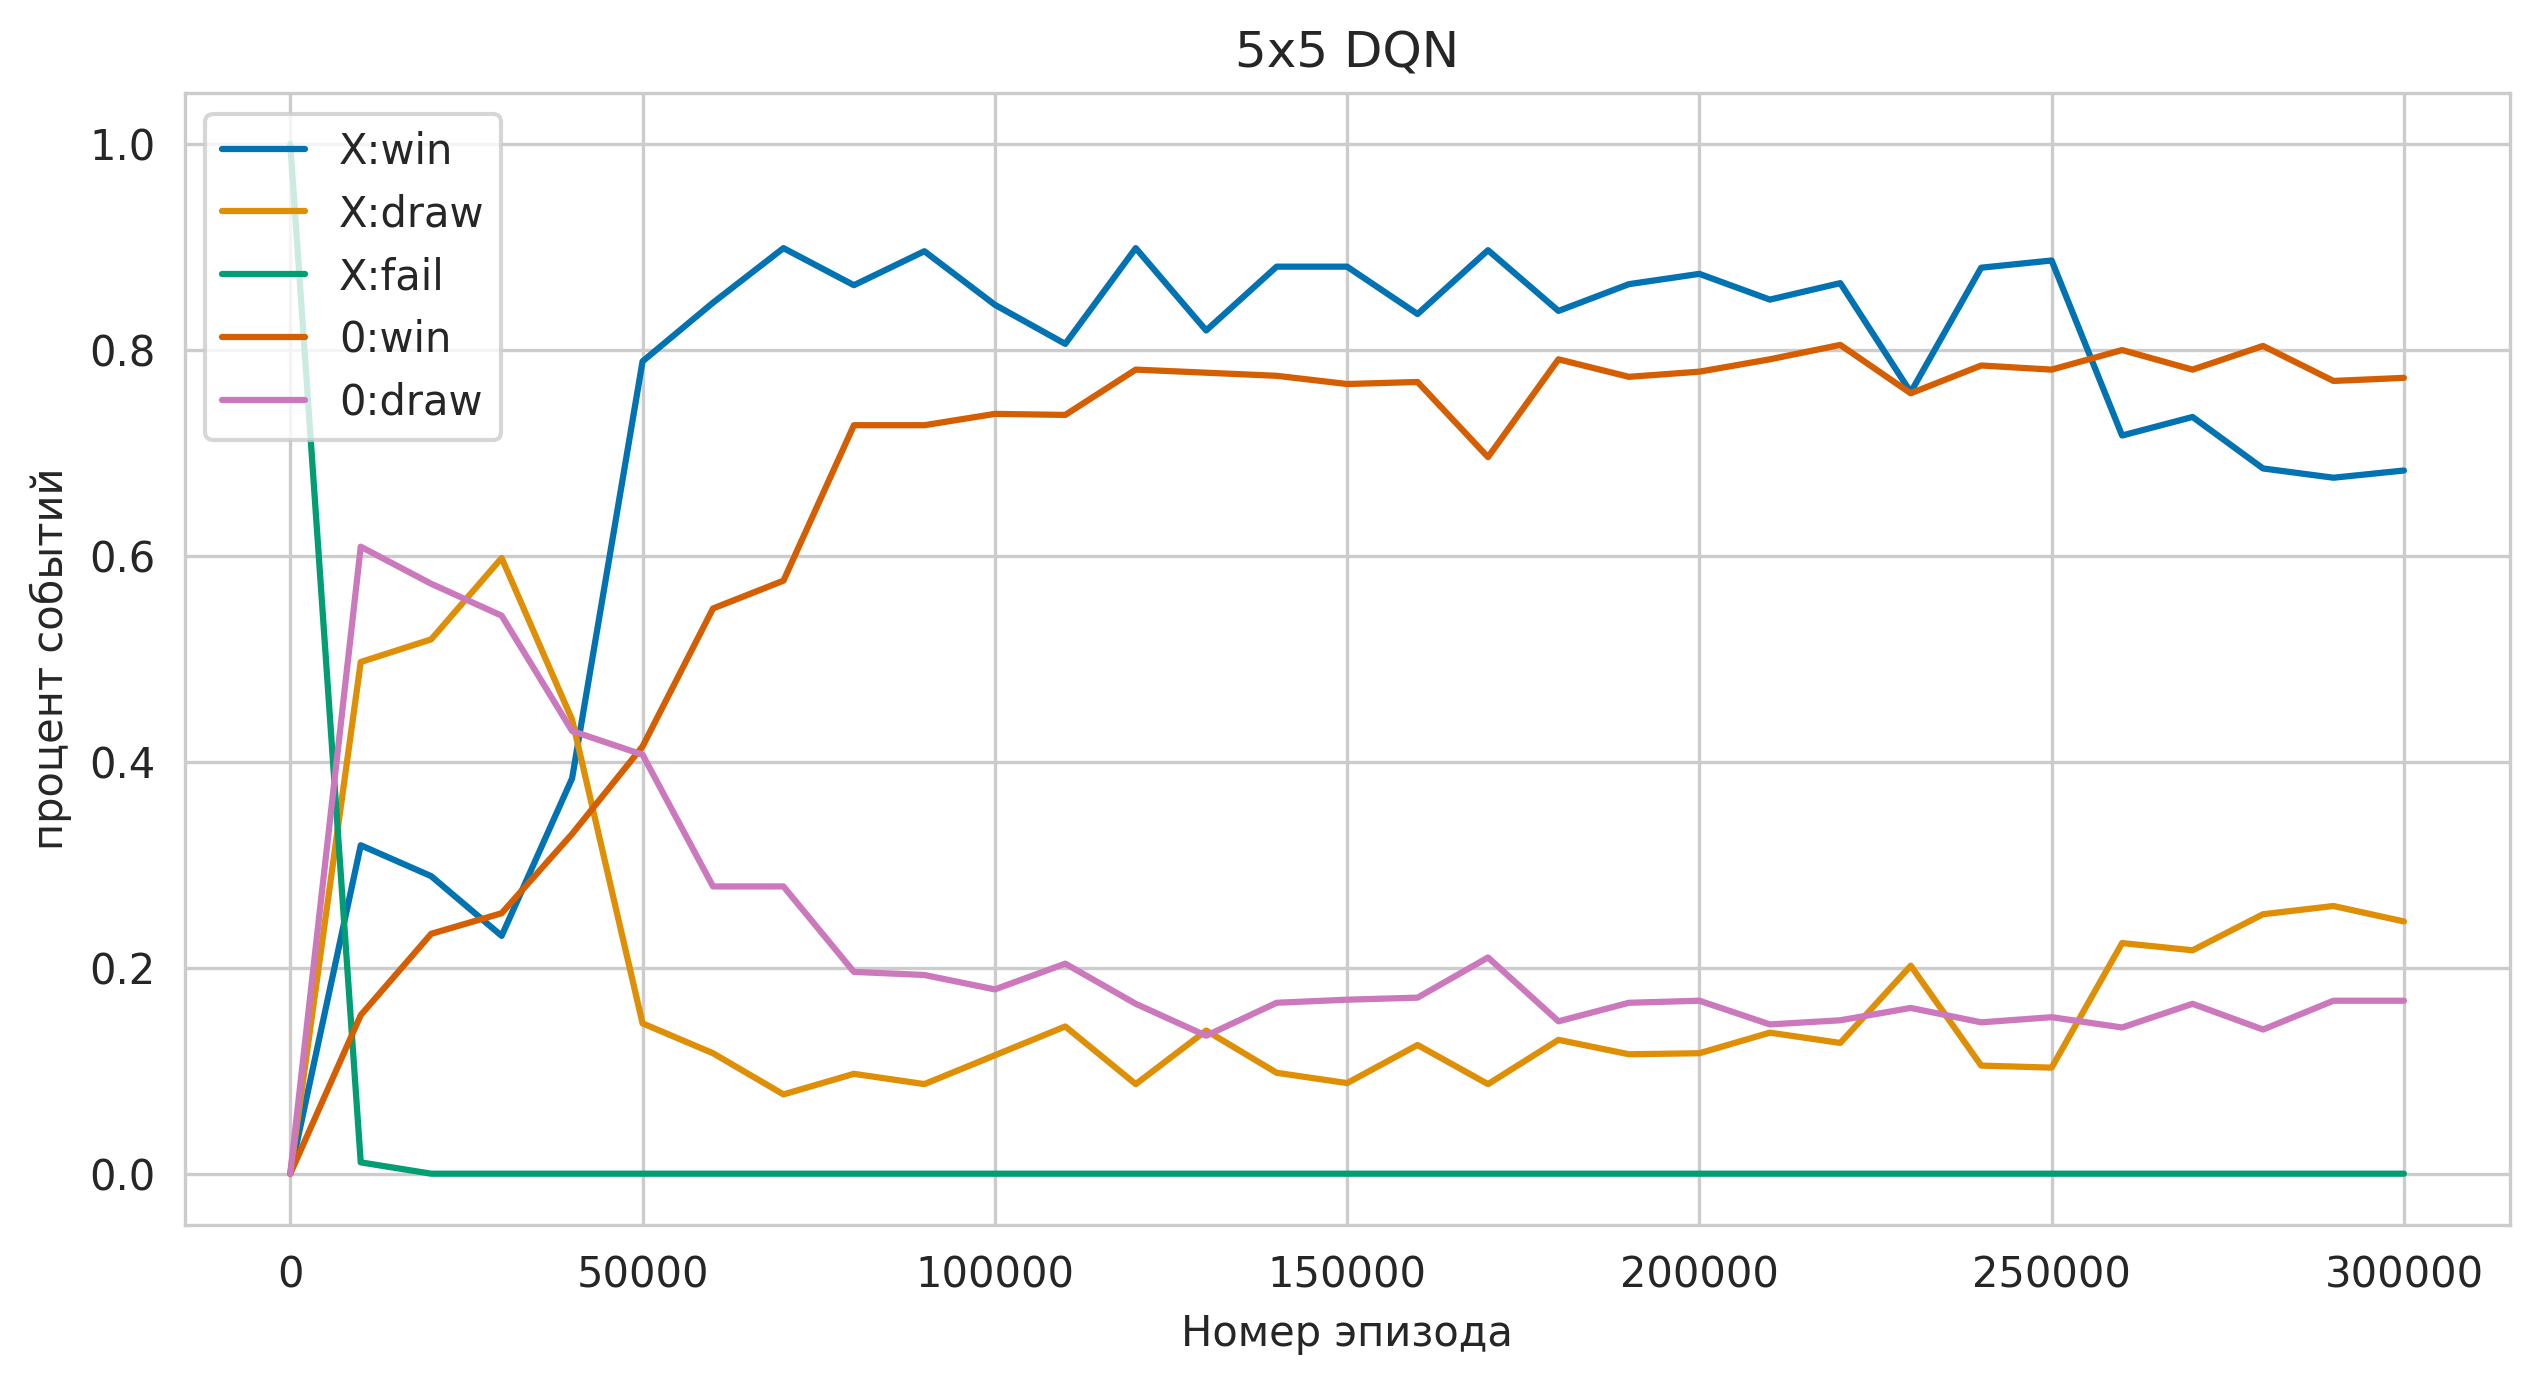

In [ ]:
%%time
env = TicTacToe(5,5,5)
modelX = ConvNetwork_5x5(env).to(device)        
model0 = ConvNetwork_5x5(env).to(device)        
dqn = TTTDQNTrainer(env,modelX,model0,print_step=10000,mem_size=1000000)
print(dqn.modelX)
print(dqn.model0)
n = 300000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("5x5 DQN",dqn.steps,dqn.episode_stat,["X:step"])

##Dueling DQN

In [ ]:
class TTTDuelingDQNTrainer():
    def __init__(self,env,modelX,targetX,model0,target0,lr=0.001,print_step=1000,mem_size=200000):
        env.reset()        
        self.env = env       
        self.modelX = modelX
        self.targetX = targetX
        self.model0 = model0  
        self.target0 = target0
        self.actions = env.getEmptySpaces()
        self.memoryX = ReplayMemory(mem_size)
        self.memory0 = ReplayMemory(mem_size)
        self.optimizerX = optim.Adam(self.modelX.parameters(), lr)
        self.optimizer0 = optim.Adam(self.model0.parameters(), lr)
        self.episode_stat = {"X:win":[],"X:draw":[],"X:fail":[],"0:win":[],"0:draw":[],"X:step":[]}
        self.steps = []
        self.gamma = 0.5
        self.discount = 0.9
        self.batch_size = 512
        # self.eps_fix = 0.5
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200000
        self.num_step = 0
        self.print_step = print_step

    def select_greedy_action(self, state, model):
        state = state.to(device)
        a = model(state).cpu().detach().data.max(1)[1].view(1, 1)        
        return a

    def select_action(self, state,model):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * math.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:            
            return self.select_greedy_action(state, model)
        else:           
            b = torch.tensor([[np.random.randint(model.out_size)]], dtype=torch.int64)
            return b

    def getState(self):
        board = self.env.board.flatten()        
        res = np.concatenate([board==-1,board==0,board==1])
        return res
        
    def run_episode(self, e=0, do_learning=True):
        self.env.reset()        
        
        notFirst = False
        while True:            
            if self.env.curTurn==1: # ход Х                
                stateX = self.getState()
                state_tensorX = torch.tensor([stateX], dtype=torch.float32)
                with torch.no_grad():
                    actionX = self.select_action(state_tensorX,self.modelX)
                actX = self.actions[actionX.numpy()[0][0]]     
                observation, reward, done, _ = self.env.step(actX)
                
                next_state0 = self.getState()
                next_state_tensor0 = torch.tensor([next_state0], dtype=torch.float32)                            
                                
                if reward!=0:
                    next_state_tensorX = torch.tensor([stateX], dtype=torch.float32)            
                    transition = (state_tensorX, actionX, next_state_tensorX, torch.tensor([reward], dtype=torch.float32), torch.tensor([done], dtype=torch.float32))
                    self.memoryX.store(transition)
                
                if notFirst and (reward==1 or reward==0):
                    rew0=-reward
                    transition = (state_tensor0, action0, next_state_tensor0, torch.tensor([rew0], dtype=torch.float32),torch.tensor([done], dtype=torch.float32))
                    self.memory0.store(transition)                                    
                    
                if do_learning:
                    self.learn(self.modelX,self.targetX,self.memoryX,self.optimizerX,1)
                    
            else:        
                notFirst = True
                state0 = self.getState()
                state_tensor0 = torch.tensor([state0], dtype=torch.float32)
                with torch.no_grad():
                    action0 = self.select_action(state_tensor0,self.model0)
                act0 = self.actions[action0.numpy()[0][0]]     
                observation, reward, done, _ = self.env.step(act0)
                                                              
                next_stateX = self.getState()
                next_state_tensorX = torch.tensor([next_stateX], dtype=torch.float32)
            
                if reward!=0:
                    next_state_tensor0 = torch.tensor([state0], dtype=torch.float32)        
                    rew0 = -reward if reward==-1 else reward
                    transition = (state_tensor0, action0, next_state_tensor0, torch.tensor([rew0], dtype=torch.float32), torch.tensor([done], dtype=torch.float32))
                    self.memory0.store(transition)
            
                if reward==-1 or reward==0:
                    transition = (state_tensorX, actionX, next_state_tensorX, torch.tensor([reward], dtype=torch.float32), torch.tensor([done], dtype=torch.float32))
                    self.memoryX.store(transition)                                                        
                    
                if do_learning:
                    self.learn(self.model0,self.target0,self.memory0,self.optimizer0,1)
                    
            if done:
                break
        if e%500==100:            
            self.targetX.load_state_dict(self.modelX.state_dict())
            self.target0.load_state_dict(self.model0.state_dict())
            
        if e%self.print_step==0:
            self.modelX.eval()                      
            piX = ModelStrategy(self.modelX)
            rX = reward_by_games(self.env,piX,pi_random)
            self.episode_stat["X:win"].append(rX["X"])
            self.episode_stat["X:draw"].append(rX["-"])
            self.episode_stat["X:fail"].append(rX["fail"])
            self.episode_stat["X:step"].append(rX["mean_step"])

            pi0 = ModelStrategy(self.model0)
            r0 = reward_by_games(self.env,pi_random,pi0)
            self.episode_stat["0:win"].append(r0["0"])
            self.episode_stat["0:draw"].append(r0["-"])                                                                            
            print(f"\t{e}:",rX,r0,f"mem:{len(self.memoryX.memory)},{len(self.memory0.memory)}")
            self.steps.append(e)
            self.modelX.train()

    def learn(self,model,target,memory,optimizer,n=1):
        if len(memory) < self.batch_size:
            return

        for i in range(n):
        # берём мини-батч из памяти
            transitions = memory.sample(self.batch_size)
            batch_state, batch_action, batch_next_state, batch_reward, batch_done = zip(*transitions)

            batch_state = Variable(torch.cat(batch_state)).to(device)
            batch_action = Variable(torch.cat(batch_action)).to(device)
            batch_reward = Variable(torch.cat(batch_reward)).to(device)
            batch_next_state = Variable(torch.cat(batch_next_state)).to(device)            
            batch_done = Variable(torch.cat(batch_done)).to(device)

            # реализация из какого-то туториала
            next_qs_argmax = model(batch_next_state).argmax(dim=-1, keepdim=True)            
            masked_next_qs = target(batch_next_state).gather(1, next_qs_argmax).squeeze()            
            trgt = batch_reward + (1.0 - batch_done) * self.discount * masked_next_qs
            masked_qs = model(batch_state).gather(1, batch_action).reshape([self.batch_size])
            loss = F.smooth_l1_loss(masked_qs, trgt.detach())
            
            optimizer.zero_grad()
            loss.backward()            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
            optimizer.step()
            
class Dueling_3x3n(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.in_size = 3*env.n_rows*env.n_cols
        self.out_size = env.n_rows*env.n_cols               
        sz_c1 = 32         
        self.hidden = (self.n_rows-(2-1))*(self.n_cols-(2-1))*sz_c1        
        self.c1 = nn.Conv2d(3,sz_c1,(2,2))        
        self.norm = nn.LayerNorm(self.hidden)                
        self.l1 = nn.Linear(self.hidden, self.hidden)
        self.V = nn.Linear(self.hidden, 1)
        self.A = nn.Linear(self.hidden, self.out_size)    

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)
        x = x.reshape(bs,-1)        
        x = self.norm(x)        
        x = torch.relu(x)
        x = self.l1(x)    
        x = torch.relu(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))            
        return Q

class Dueling_4x4n(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.in_size = 3*env.n_rows*env.n_cols
        self.out_size = env.n_rows*env.n_cols
        sz_c1 = 16        
        self.hidden1 = 128
        self.hidden2 = 64
        self.c1 = nn.Conv2d(3,sz_c1,(3,3))        
        self.c2 = nn.Conv2d(sz_c1,self.hidden1,(2,2))
        self.norm = nn.LayerNorm(self.hidden1)                        
        self.l1 = nn.Linear(self.hidden1, self.hidden2)
        
        self.V = nn.Linear(self.hidden2, 1)
        self.A = nn.Linear(self.hidden2, self.out_size)

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x1 = self.c1(x)        
        x1 = torch.relu(x1)
        x1 = self.c2(x1)        
        x1 = x1.reshape(bs,-1)                
        x1 = self.norm(x1)        
        x1 = torch.relu(x1)
        x1 = self.l1(x1)
        x1 = torch.relu(x1)
        
        V = self.V(x1)
        A = self.A(x1)
        Q = V + (A - A.mean(dim=1, keepdim=True))                
        return Q


class Dueling_5x5n(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.out_size = env.n_rows*env.n_cols
        sz_c1 = 16
        self.hidden1 = 256
        self.hidden2 = 128
        self.c1 = nn.Conv2d(3,sz_c1,(3,3))                 
        self.c2 = nn.Conv2d(sz_c1,self.hidden1,(3,3))  
        self.norm = nn.LayerNorm(self.hidden1)                        
        self.l1 = nn.Linear(self.hidden1, self.hidden2)
        self.V = nn.Linear(self.hidden2, 1)
        self.A = nn.Linear(self.hidden2, self.out_size)

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)      
        x = torch.relu(x)
        x = self.c2(x)        
        x = x.reshape(bs,-1)      
                  
        x = self.norm(x)        
        x = torch.relu(x)
        x = self.l1(x)
        x = torch.relu(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))            
        return Q                      

### 3x3

Dueling_3x3n(
  (c1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=128, bias=True)
  (V): Linear(in_features=128, out_features=1, bias=True)
  (A): Linear(in_features=128, out_features=9, bias=True)
)
Dueling_3x3n(
  (c1): Conv2d(3, 32, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=128, bias=True)
  (V): Linear(in_features=128, out_features=1, bias=True)
  (A): Linear(in_features=128, out_features=9, bias=True)
)
params = 18474
05:51:31.422127	Starting training for 40000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.49} {'X': 0.069, '0': 0.002, '-': 0.0, 'fail': 0.929, 'mean_step': 4.415} mem:3,1
	2000: {'X': 0.842, '0': 0.111, '-': 0.047, 'fail': 0.0, 'mean_step': 6.713} {'X': 0.327, '0': 0.557, '-': 0.116, 'fail': 0.0, 'mean_step': 6.913} mem:4089,

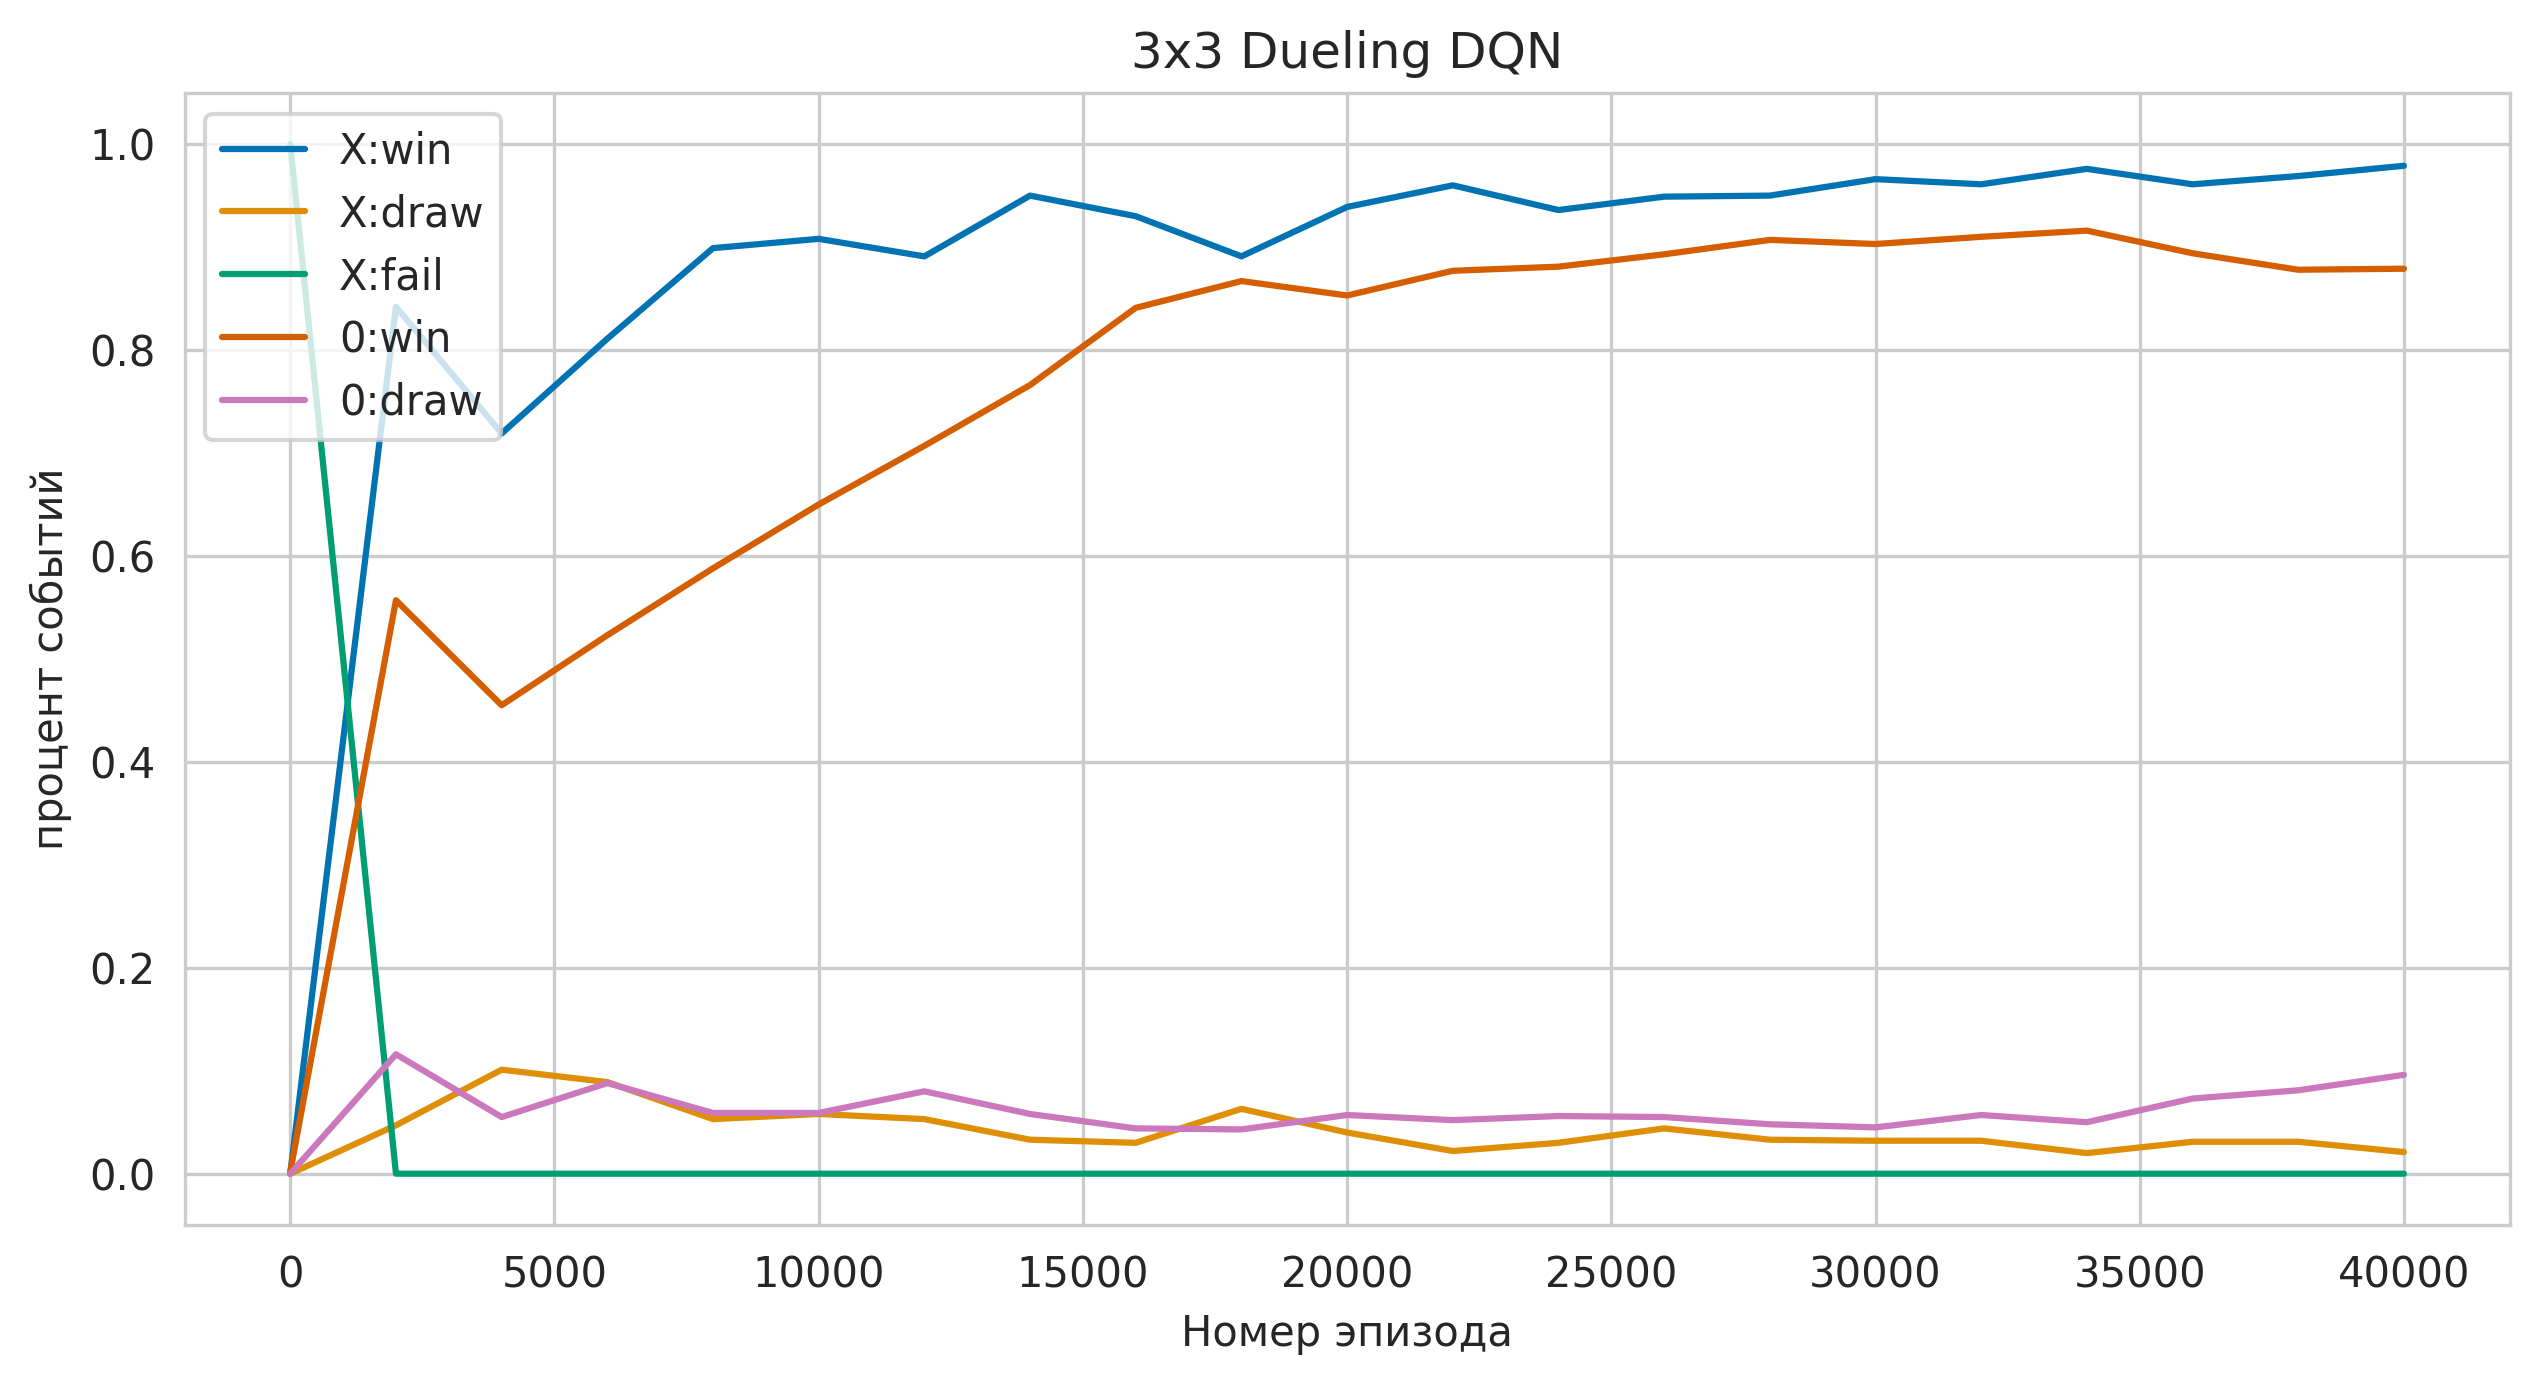

In [ ]:
%%time
env = TicTacToe(3,3,3)
modelX = Dueling_3x3n(env).to(device)
targetX = Dueling_3x3n(env).to(device)
model0 = Dueling_3x3n(env).to(device) 
target0 = Dueling_3x3n(env).to(device)
dqn = TTTDuelingDQNTrainer(env,modelX,targetX,model0,target0,lr=0.0001,print_step=2000, mem_size=200000)
print(dqn.modelX)
print(dqn.model0)
print(f'params = {sum(p.numel() for p in modelX.parameters() if p.requires_grad)}')
n = 40000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("3x3 Dueling DQN",dqn.steps,dqn.episode_stat,["X:step"])

### 4x4

Dueling_4x4n(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=64, bias=True)
  (V): Linear(in_features=64, out_features=1, bias=True)
  (A): Linear(in_features=64, out_features=16, bias=True)
)
Dueling_4x4n(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 128, kernel_size=(2, 2), stride=(1, 1))
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=128, out_features=64, bias=True)
  (V): Linear(in_features=64, out_features=1, bias=True)
  (A): Linear(in_features=64, out_features=16, bias=True)
)
params = 18385
06:19:39.904071	Starting training for 100000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.0} {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.898} mem:2,0
	5000: {'X': 0.424, '0': 0.194, '-': 0.382, 'fai

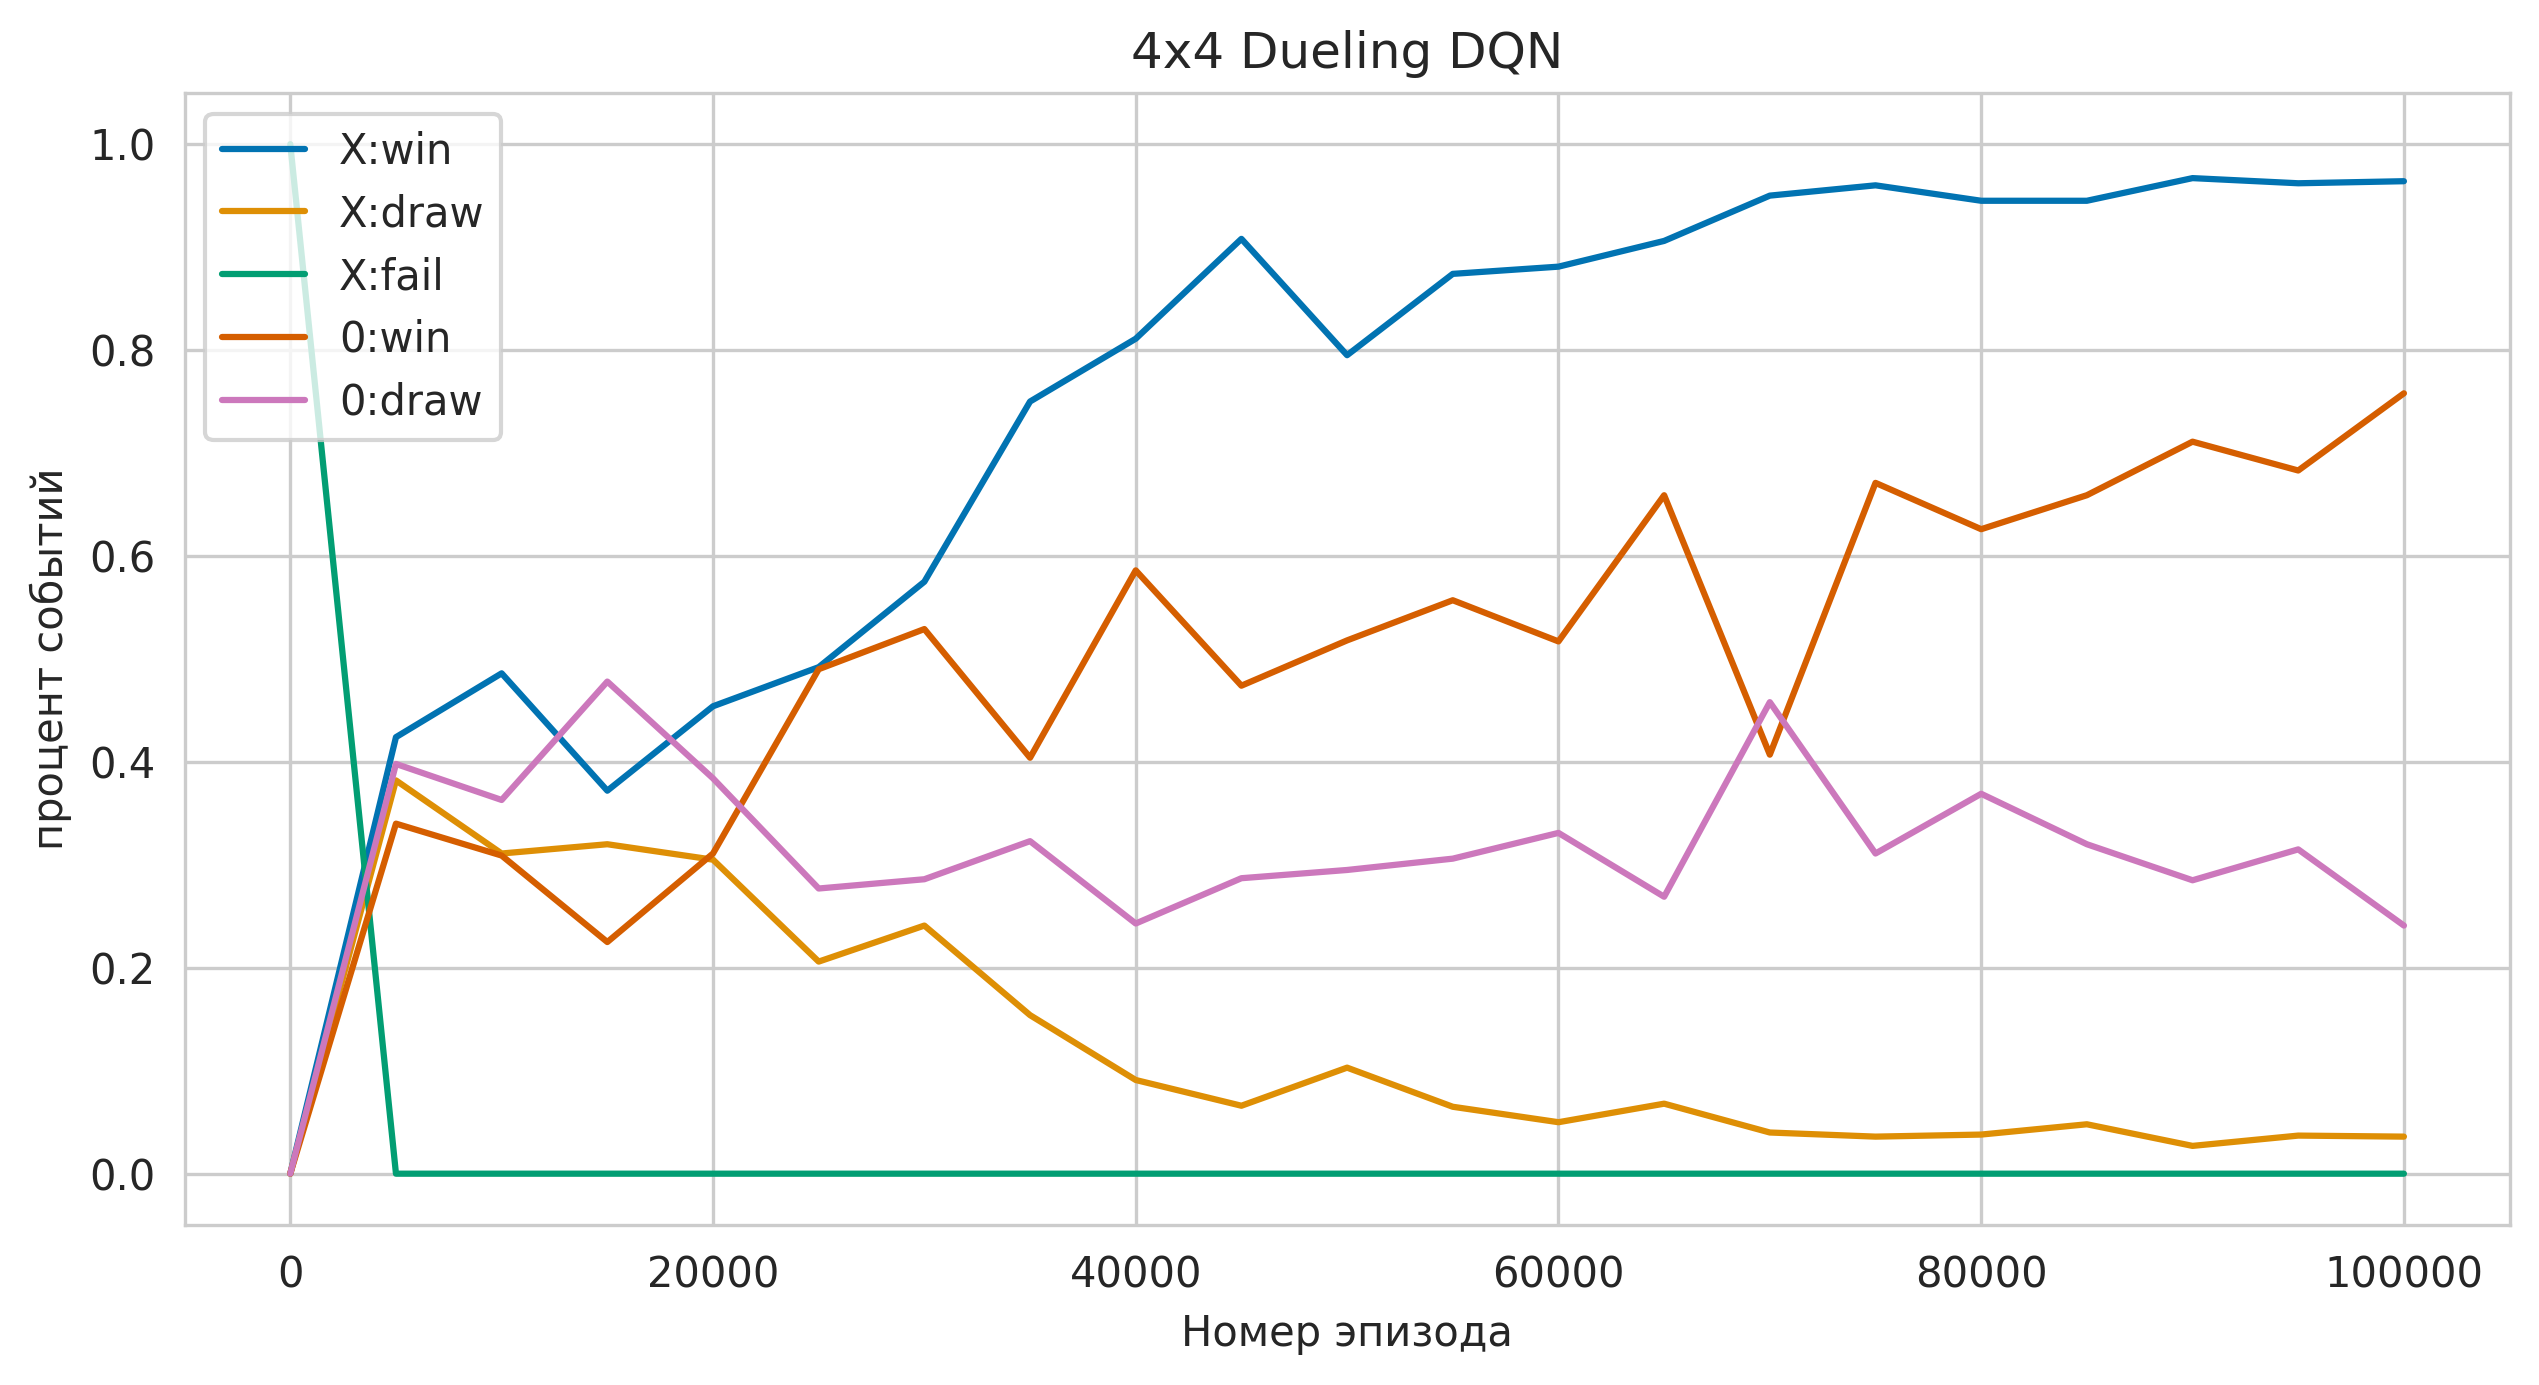

In [ ]:
%%time
env = TicTacToe(4,4,4)
modelX = Dueling_4x4n(env).to(device)
targetX = Dueling_4x4n(env).to(device)
model0 = Dueling_4x4n(env).to(device)
target0 = Dueling_4x4n(env).to(device)
dqn = TTTDuelingDQNTrainer(env,modelX,targetX,model0,target0,lr=0.0001,print_step=5000,mem_size=500000)
print(dqn.modelX)
print(dqn.model0)
print(f'params = {sum(p.numel() for p in modelX.parameters())}')
n = 100000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("4x4 Dueling DQN",dqn.steps,dqn.episode_stat,["X:step"])

### 5x5

Dueling_5x5n(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=256, out_features=128, bias=True)
  (V): Linear(in_features=128, out_features=1, bias=True)
  (A): Linear(in_features=128, out_features=25, bias=True)
)
Dueling_5x5n(
  (c1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (c2): Conv2d(16, 256, kernel_size=(3, 3), stride=(1, 1))
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (l1): Linear(in_features=256, out_features=128, bias=True)
  (V): Linear(in_features=128, out_features=1, bias=True)
  (A): Linear(in_features=128, out_features=25, bias=True)
)
params = 74330
21:11:27.063941	Starting training for 120000 episodes...
	0: {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 3.256} {'X': 0.0, '0': 0.0, '-': 0.0, 'fail': 1.0, 'mean_step': 4.162} mem:5,6
	5000: {'X': 0.18, '0': 0.147, '-': 0.33

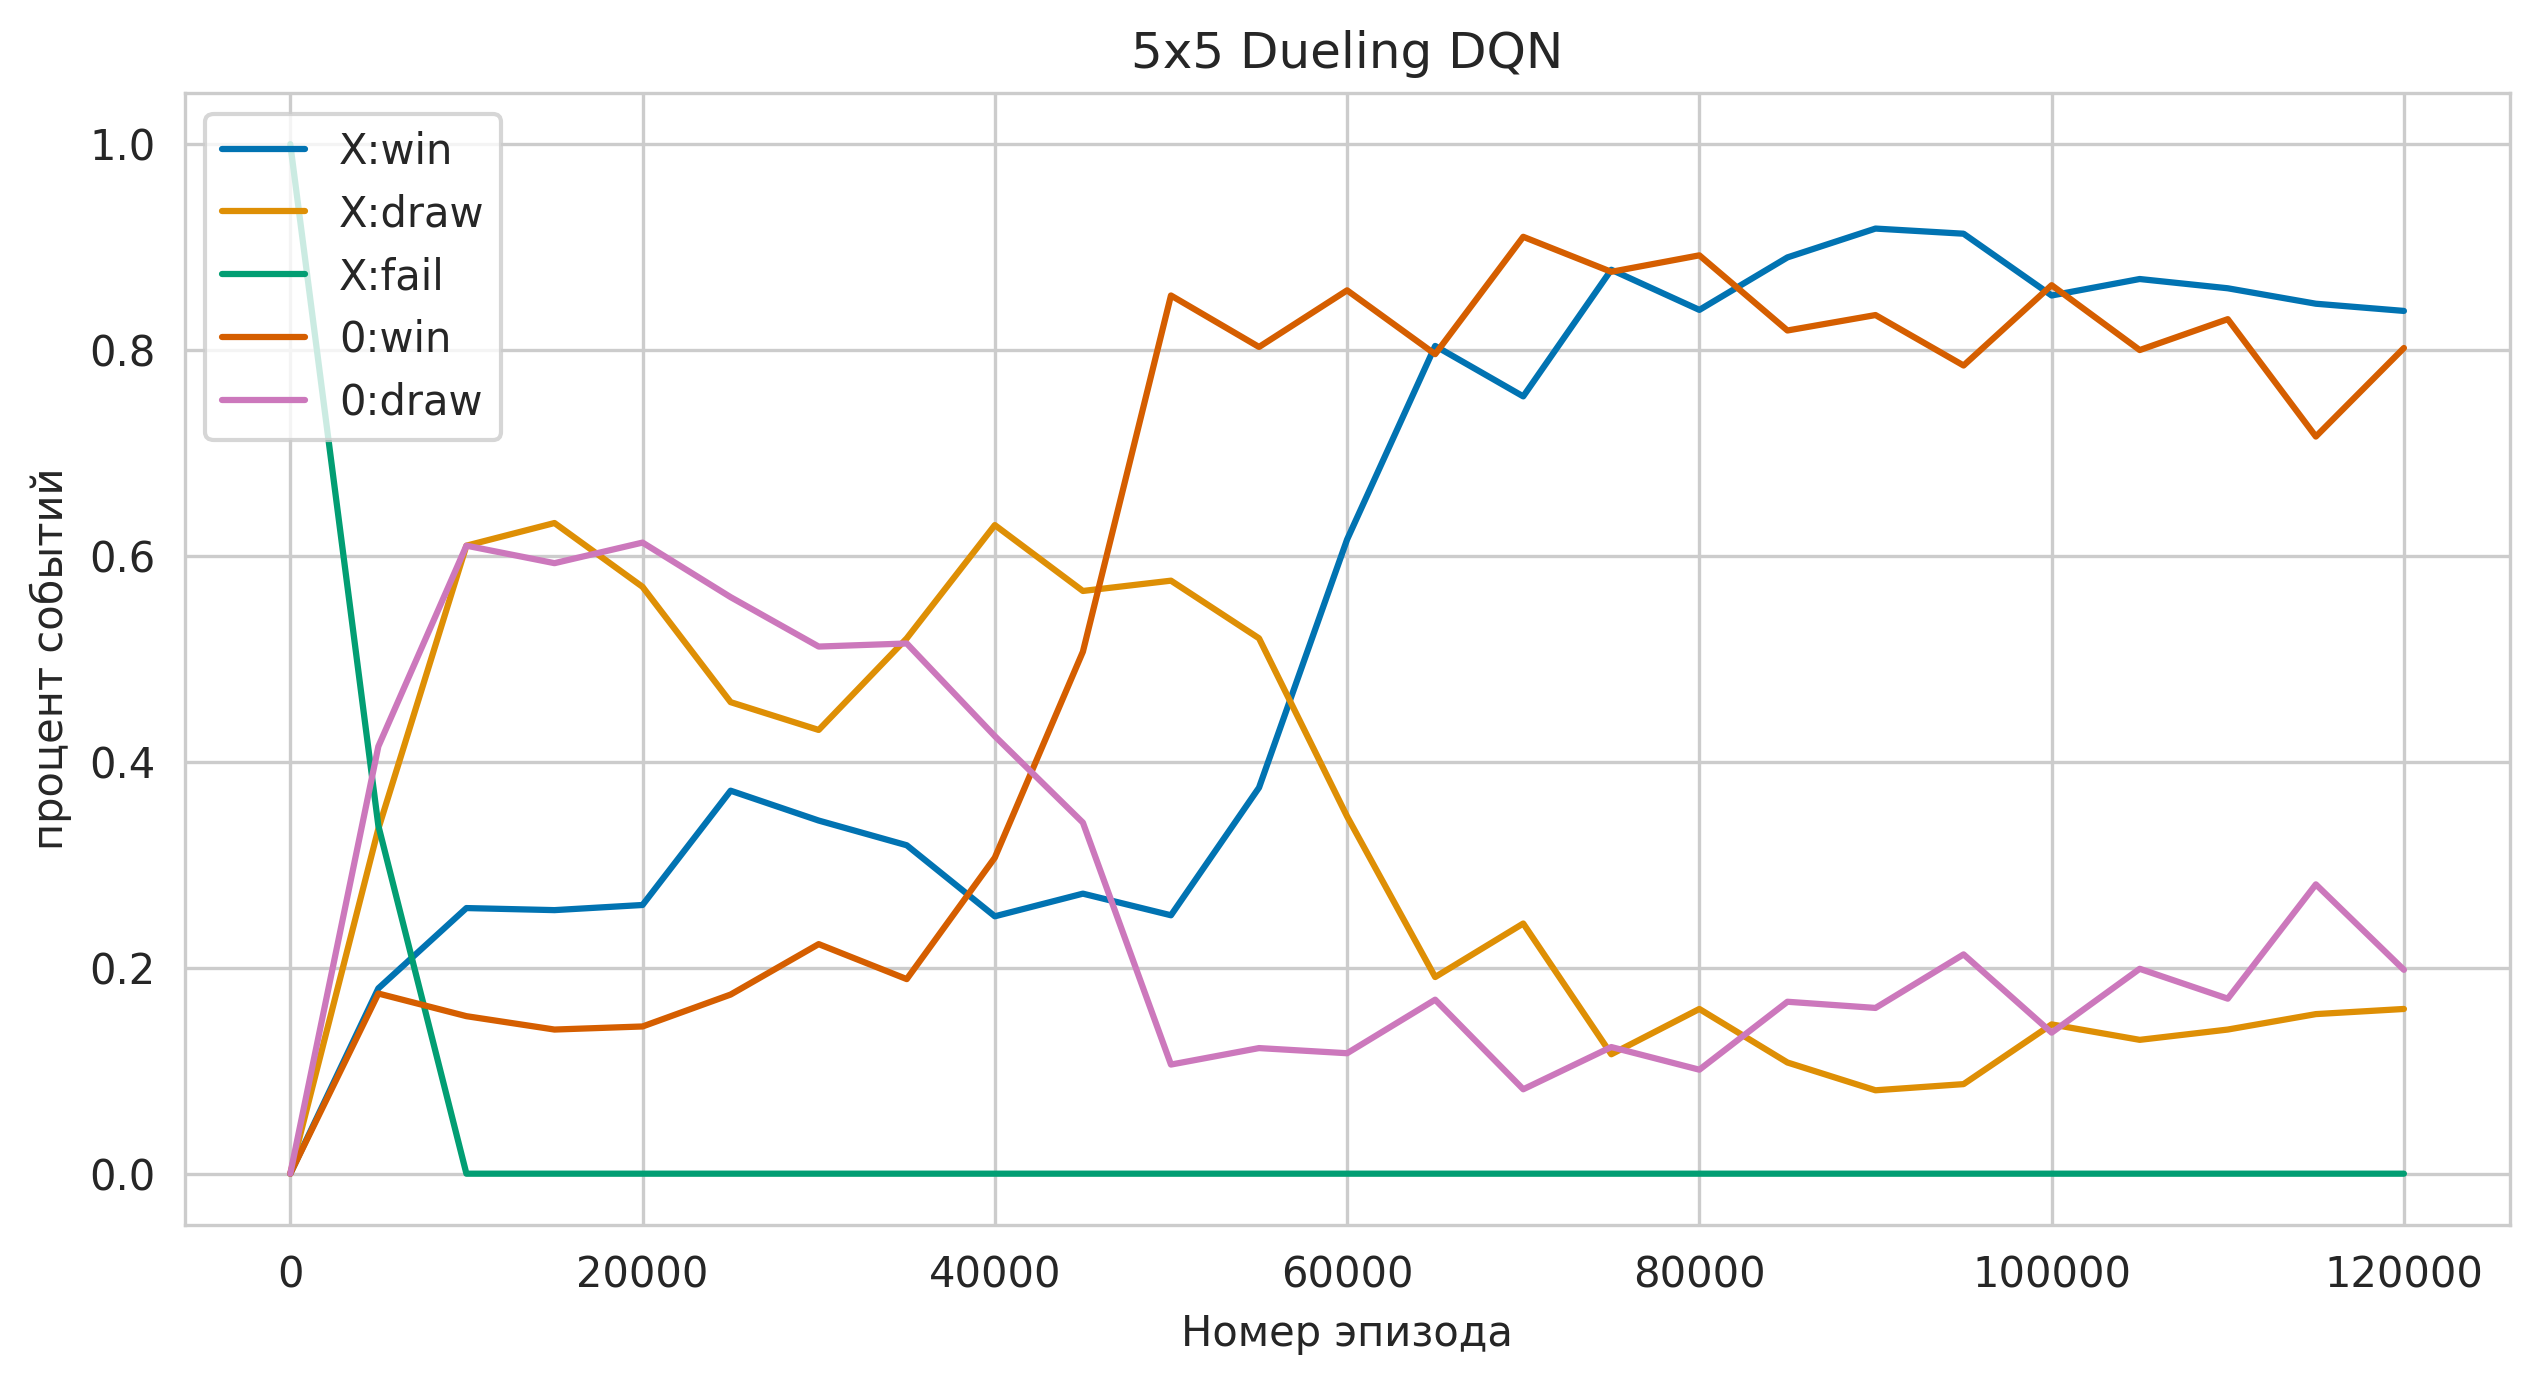

In [ ]:
%%time
env = TicTacToe(5,5,5)
modelX = Dueling_5x5n(env).to(device)
targetX = Dueling_5x5n(env).to(device)
model0 = Dueling_5x5n(env).to(device) 
target0 = Dueling_5x5n(env).to(device)
dqn = TTTDuelingDQNTrainer(env,modelX,targetX,model0,target0,lr=0.0001,print_step=5000,mem_size=1000000)
print(dqn.modelX)
print(dqn.model0)
print(f'params = {sum(p.numel() for p in modelX.parameters())}')
n = 120000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(n+1):
    dqn.run_episode(e)
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("5x5 Dueling DQN",dqn.steps,dqn.episode_stat,["X:step"])

### 10x10x5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/My Drive/models'

def save_model(name,epoch,model,model_size):
  fn = f'{drive_path}/{model_size}_{name}_{epoch}.pth' 
  torch.save(model.state_dict(), fn)
  
def save_models(model_size,epoch,modelX,targetX,model0,target0):
  save_model("mX",epoch,modelX,model_size)
  save_model("m0",epoch,model0,model_size)
  save_model("tX",epoch,targetX,model_size)
  save_model("t0",epoch,target0,model_size)

def load_params(model_size,name,epoch):
  fn = f'{drive_path}/{model_size}_{name}_{epoch}.pth'
  return torch.load(fn)

In [ ]:
class Dueling_10x10n_64(nn.Module):
    def __init__(self,env):
        nn.Module.__init__(self)
        self.n_rows = env.n_rows
        self.n_cols = env.n_cols
        self.out_size = env.n_rows*env.n_cols
        sz_c1 = 16
        self.hidden1 = 64
        self.hidden2 = 2304
        self.c1 = nn.Conv2d(3,sz_c1,(3,3))                 
        self.c2 = nn.Conv2d(sz_c1,self.hidden1,(3,3))  
        self.norm = nn.LayerNorm(self.hidden2)                        
        self.l1 = nn.Linear(self.hidden2, self.hidden2)
        self.V = nn.Linear(self.hidden2, 1)
        self.A = nn.Linear(self.hidden2, self.out_size)

    def forward(self, x):
        bs = x.shape[0]        
        x = x.reshape(bs,3,self.n_rows,self.n_cols)
        x = self.c1(x)      
        x = torch.relu(x)
        x = self.c2(x)        
        x = x.reshape(bs,-1)              
        x = self.norm(x)                
        x = torch.flatten(x, 1)                  
        x = torch.relu(x)        
        x = self.l1(x)
        x = torch.relu(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))            
        return Q

In [ ]:
# %%time
env = TicTacToe(10,10,5)
modelX = Dueling_10x10n_64(env)
targetX = Dueling_10x10n_64(env)
model0 = Dueling_10x10n_64(env)
target0 = Dueling_10x10n_64(env)
model_size = '10x10_2_'
load_epoch = -1

# load_epoch = 11000
if load_epoch>=0:
  modelX.load_state_dict(load_params(model_size,'mX',load_epoch))
  targetX.load_state_dict(load_params(model_size,'tX',load_epoch))
  model0.load_state_dict(load_params(model_size,'m0',load_epoch))
  target0.load_state_dict(load_params(model_size,'t0',load_epoch))
  print(f"load params. epoch={load_epoch}")

modelX.to(device)
targetX.to(device)
model0.to(device)
target0.to(device)
dqn = TTTDuelingDQNTrainer(env,modelX,targetX,model0,target0,lr=0.0001,mem_size=1000000)
print(dqn.modelX)
print(dqn.model0)
print(f'params = {sum(p.numel() for p in modelX.parameters() if p.requires_grad)}')
n = 20000
step = 1000
print(f"{(datetime.now().time())}\tStarting training for {n} episodes...")
for e in range(load_epoch+1,n+1):
    dqn.run_episode(e)
    if e%step==0:
      save_model("mX",e,modelX,model_size)
      save_model("tX",e,targetX,model_size)
      save_model("m0",e,model0,model_size)  
      save_model("t0",e,target0,model_size)

    
print("%s\t\t...done!" % (datetime.now().time()))
plot_durations("10x10x5 Dueling DQN",dqn.steps,dqn.episode_stat,["X:step"])

	21000: {'X': 0.573, '0': 0.298, '-': 0.0, 'fail': 0.129, 'mean_step': 57.812} {'X': 0.448, '0': 0.37, '-': 0.0, 'fail': 0.182, 'mean_step': 60.558} mem:79832,74743
	22000: {'X': 0.569, '0': 0.335, '-': 0.0, 'fail': 0.096, 'mean_step': 58.515} {'X': 0.419, '0': 0.384, '-': 0.0, 'fail': 0.197, 'mean_step': 59.473} mem:89785,84201
	23000: {'X': 0.55, '0': 0.348, '-': 0.0, 'fail': 0.102, 'mean_step': 59.08} {'X': 0.419, '0': 0.409, '-': 0.0, 'fail': 0.172, 'mean_step': 60.177} mem:100519,94421
	24000: {'X': 0.558, '0': 0.369, '-': 0.0, 'fail': 0.073, 'mean_step': 59.375} {'X': 0.444, '0': 0.422, '-': 0.0, 'fail': 0.134, 'mean_step': 60.996} mem:111265,104733
	25000: {'X': 0.642, '0': 0.309, '-': 0.0, 'fail': 0.049, 'mean_step': 58.095} {'X': 0.465, '0': 0.423, '-': 0.0, 'fail': 0.112, 'mean_step': 60.741} mem:122515,115443
	26000: {'X': 0.594, '0': 0.346, '-': 0.0, 'fail': 0.06, 'mean_step': 59.054} {'X': 0.43, '0': 0.434, '-': 0.0, 'fail': 0.136, 'mean_step': 60.582} mem:134210,126646
	2

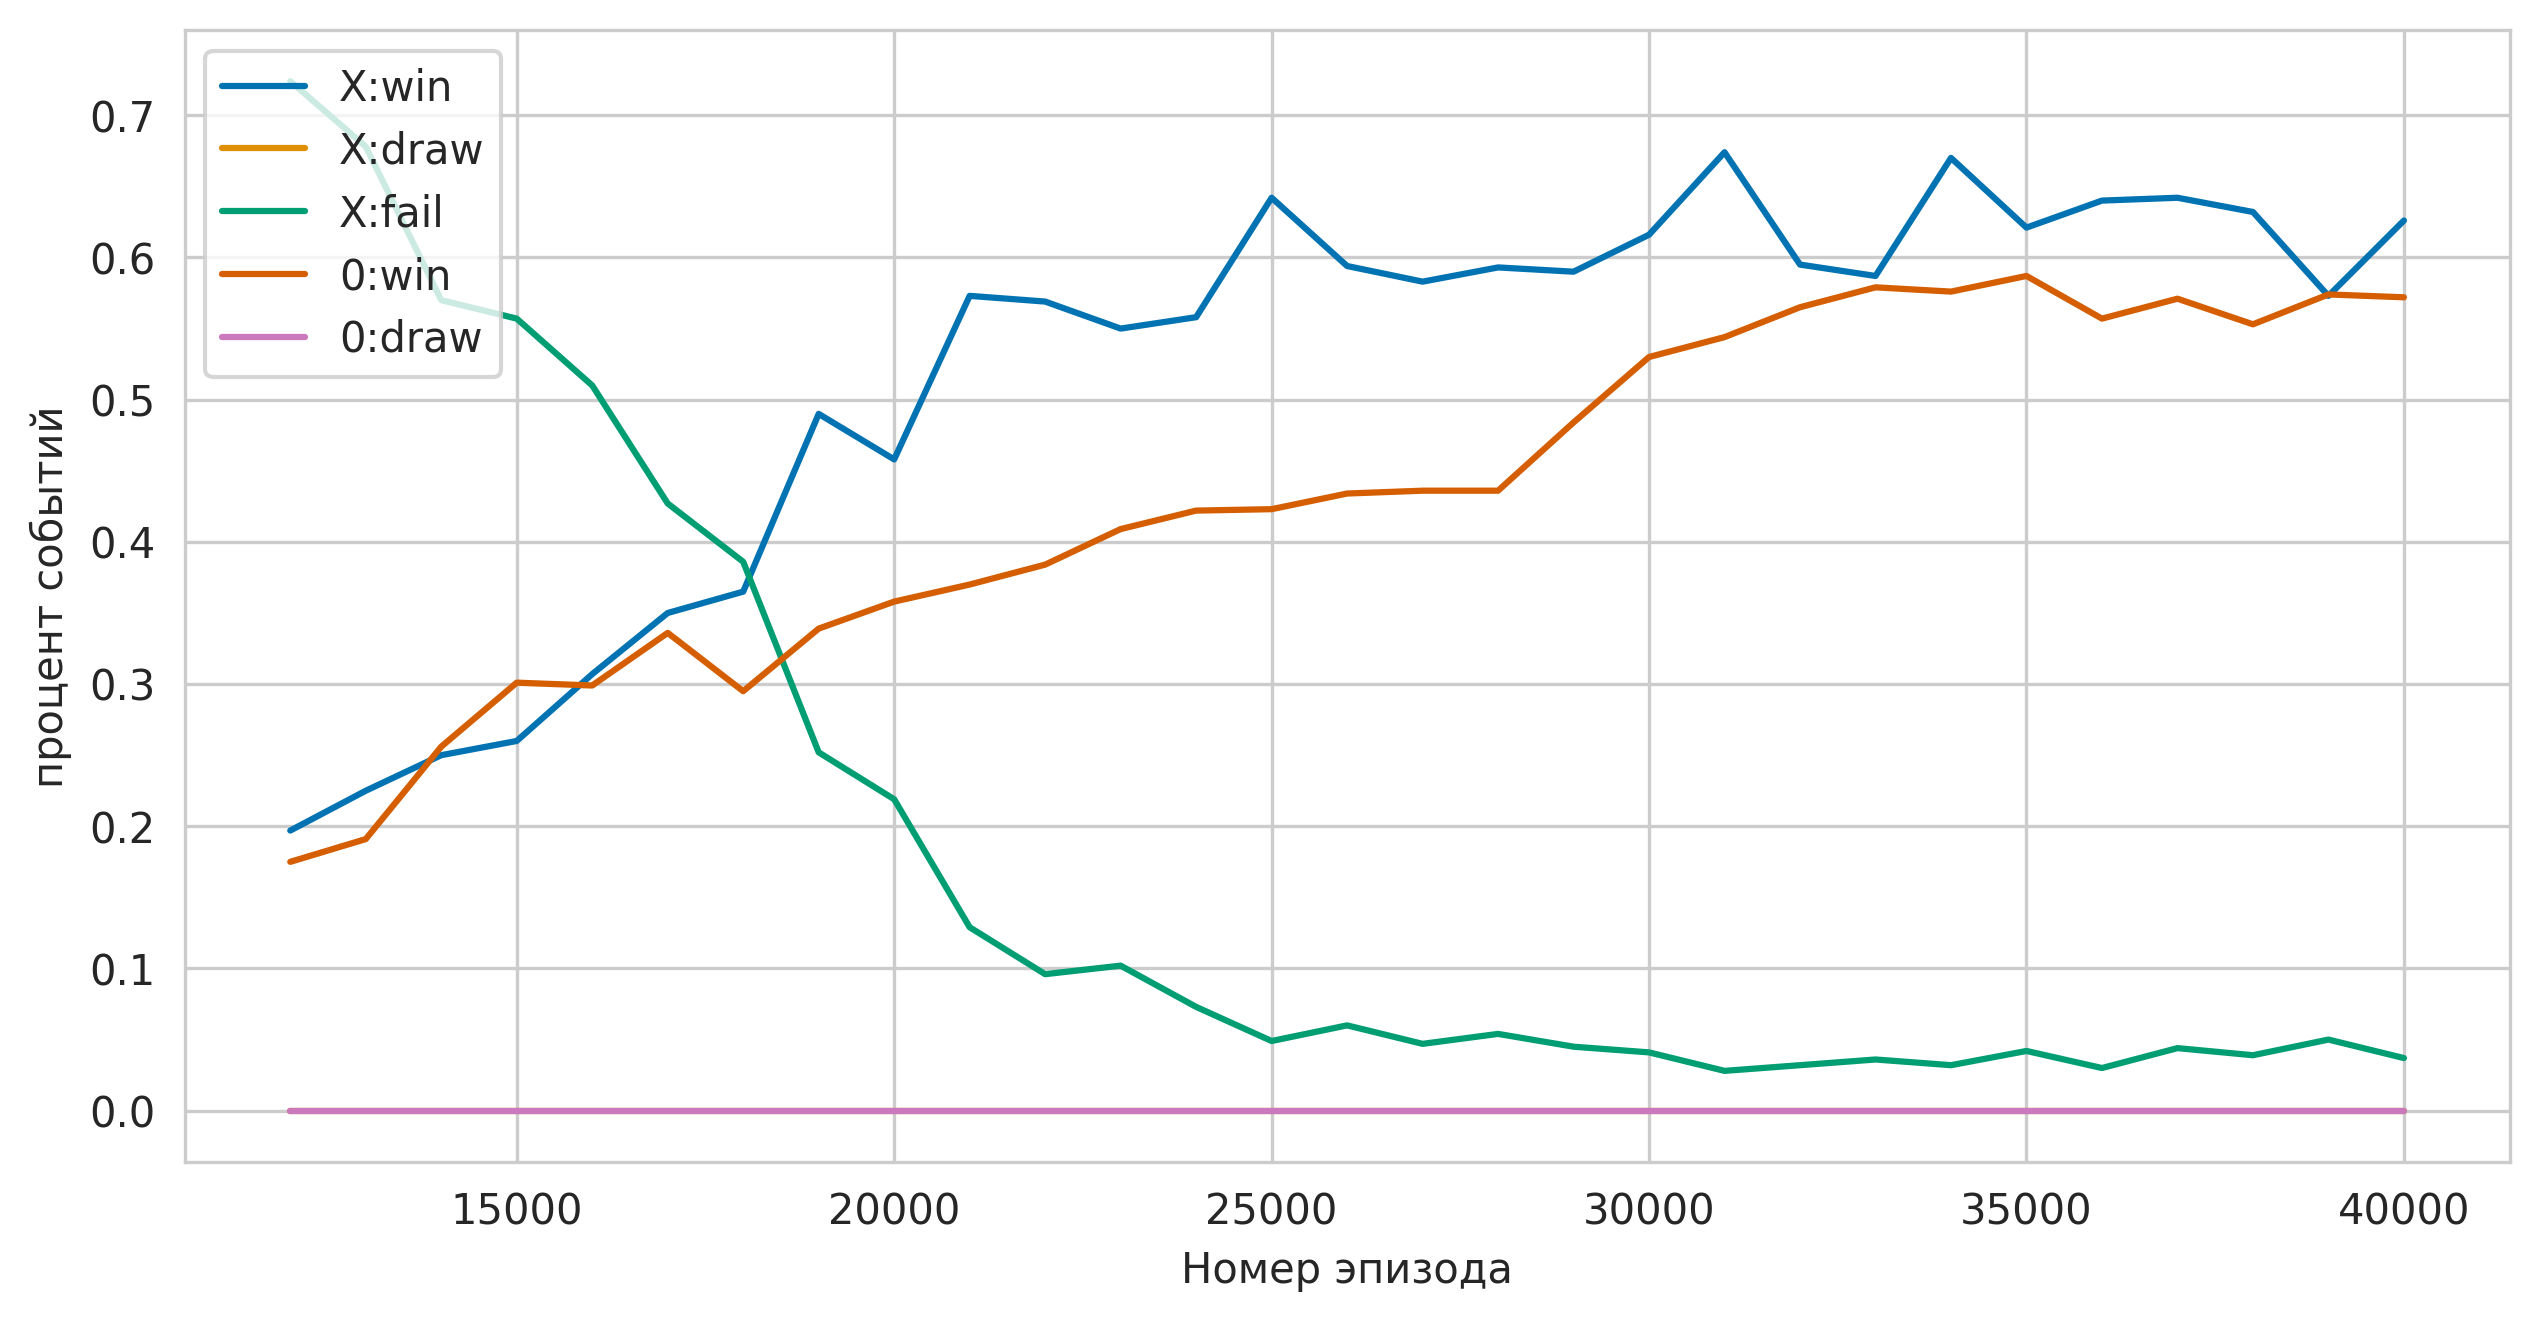

In [ ]:
for e in range(1*n+1,2*n+1):
    dqn.run_episode(e)
    if e%step==0:
      save_model("mX",e,modelX,model_size)
      save_model("tX",e,targetX,model_size)
      save_model("m0",e,model0,model_size)  
      save_model("t0",e,target0,model_size)

print("%s\t\t...done!" % (datetime.now().time()))
plot_durations(dqn.steps,dqn.episode_stat,["X:step"])

# 3. Часть третья: расширим и углубим поиск

## Rollouts

In [ ]:
class RolloutStrategy(object):
    """ Стратегия - порожденная некоторой стратегией и использующая rollouts 
    pi - XOStrategy
    """
    def __init__(self,pi,pi_random = RandomStrategy(),n=50):
        self.pi = pi # это будет сразу стратегия за обоих
        self.pi_random = pi_random
        self.n = n
        
    def __str__(self):
        return "[rollout]"
    
    def select(self,env):
        spaces = env.getEmptySpaces()
        result = []        
        for pos in spaces:                        
            res = rollouts(env,pos,self.pi,self.pi_random,n=self.n)
            result.append(res)
        result=env.curTurn*np.array(result)
        idx = np.argmax(result)
        action = spaces[idx]
        return env.int_from_action(action),action,idx

def rollouts(env,pos,pi,pi_random,n=10):
    player = env.curTurn
    rewards = []    
    for i in range(n):
        envNode = copy.deepcopy(env)    
        observation, reward, is_done, info = envNode.step(pos)    
        while not is_done:
            if envNode.curTurn==player:
                idx,action,_ = pi.select(envNode)
            else:
                idx,action,_ = pi_random.select(envNode)
            observation, reward, is_done, info = envNode.step(action)    
        rewards.append(reward)
    return np.mean(rewards)

### 3x3

In [ ]:
%%time
env = TicTacToe(3,3,3)
pi = RolloutStrategy(pi_random,pi_random,n=100)
reward_ro = reward_by_games(env,pi,pi_random,N=100)
print("V(rollout X)=",reward_ro, "pi_ro=",pi)

V(rollout X)= {'X': 0.98, '0': 0.0, '-': 0.02, 'fail': 0.0, 'mean_step': 5.64} pi_ro= [rollout]
CPU times: user 1min 25s, sys: 61 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
%%time
env = TicTacToe(3,3,3)
pi = RolloutStrategy(pi_random,pi_random,n=50)
reward_ro = reward_by_games(env,pi_random,pi,N=100)
print("V(rollout 0)=",reward_ro, "pi_ro=",pi)

V(rollout 0)= {'X': 0.04, '0': 0.92, '-': 0.04, 'fail': 0.0, 'mean_step': 6.48} pi_ro= [rollout]
CPU times: user 32.3 s, sys: 33 ms, total: 32.4 s
Wall time: 32.3 s


### 4x4

In [ ]:
%%time
env = TicTacToe(4,4,4)
pi = RolloutStrategy(pi_random,pi_random,n=50)
reward_ro = reward_by_games(env,pi,pi_random,N=100)
print("V(rollout X)=",reward_ro, "pi_ro=",pi)

V(rollout X)= {'X': 0.96, '0': 0.0, '-': 0.04, 'fail': 0.0, 'mean_step': 9.02} pi_ro= [rollout]
CPU times: user 4min 31s, sys: 132 ms, total: 4min 31s
Wall time: 4min 31s


In [ ]:
%%time
env = TicTacToe(4,4,4)
pi = RolloutStrategy(pi_random,pi_random,n=50)
reward_ro = reward_by_games(env,pi_random,pi,N=100)
print("V(rollout 0)=",reward_ro, "pi_ro=",pi)

V(rollout 0)= {'X': 0.0, '0': 0.9, '-': 0.1, 'fail': 0.0, 'mean_step': 10.38} pi_ro= [rollout]
CPU times: user 3min 56s, sys: 103 ms, total: 3min 56s
Wall time: 3min 57s


### 5x5

In [ ]:
%%time
env = TicTacToe(5,5,5)
pi = RolloutStrategy(pi_random,pi_random,n=50)
reward_ro = reward_by_games(env,pi,pi_random,N=100)
print("V(rollout X)=",reward_ro, "pi_ro=",pi)

V(rollout X)= {'X': 0.97, '0': 0.0, '-': 0.03, 'fail': 0.0, 'mean_step': 12.74} pi_ro= [rollout]
CPU times: user 19min 55s, sys: 550 ms, total: 19min 55s
Wall time: 19min 56s


In [ ]:
%%time
env = TicTacToe(5,5,5)
pi = RolloutStrategy(pi_random,pi_random,n=50)
reward_ro = reward_by_games(env,pi_random,pi,N=100)
print("V(rollout 0)=",reward_ro, "pi_ro=",pi)

V(rollout 0)= {'X': 0.0, '0': 0.91, '-': 0.09, 'fail': 0.0, 'mean_step': 14.07} pi_ro= [rollout]
CPU times: user 17min 55s, sys: 468 ms, total: 17min 55s
Wall time: 17min 56s


## MCTS

In [ ]:
class MCTSTree(object):
    """ Дерево """
    def __init__(self,env,pi,exploration): 
        self.env = copy.deepcopy(env)        
        self.env.reset()
        self.pi = pi
        self.exploration = exploration
        self.leaves = {}        
        self.root = self.getNode(self.env,None,1)
        
    def findNode(self,state):
        """ находит вершину по состоянию """
        try:            
            return self.leaves[state]
        except:
            return None
        
    def getNode(self,env,parent,player):
        """ Ищет вершину и если не находит - создает """
        state = env.getState()[0]
        node = self.findNode(state)        
        if node is None:
            node = Node(env,player)
            self.leaves[state] = node        
        node.updateParents(parent)
        return node
    
    def go(self):
        envGo = copy.deepcopy(self.env)
        
        node = self.root
        is_done = False
        while not is_done:
            if node.closed:
                break
            next_node, action = self.uct(node)                            
            if next_node is None:
                break
            envGo.step(action)
            node = next_node
        return node,envGo
    
    def uct(self,node):
        mx = -1
        child_mx = None
        idx_mx = -1
        for idx,childState in enumerate(node.childes()):        
            c = self.findNode(childState)
            if c is not None:
                u = c.uct(node,self.exploration)
                if u>mx:
                    mx = u
                    child_mx = c
                    idx_mx = idx
        if mx==-1:
            return None,(-1,-1)        
        return child_mx, node.actions[idx_mx]

    def best(self,node):
        mx = -1
        child_mx = None
        idx_mx = -1
        for idx,childState in enumerate(node.childes()):        
            c = self.findNode(childState)
            if c is not None:
                u = c.wins_part(node)
                if u>mx:
                    mx = u
                    child_mx = c
                    idx_mx = idx
        if mx==-1:
            return (-1,-1)        
        return node.actions[idx_mx]
    
    def step(self):
        leaf, envGo = self.go() 
        if not leaf.terminal:
            self.buildChild(leaf,envGo)
        else:                     
            self.backprop(leaf,leaf.stat/leaf.stat[1],True)
            
    def buildChild(self, leaf, env):
        
        spaces = env.getEmptySpaces().copy()
        stat = np.zeros(3)
        for pos in spaces:
            envNode = copy.deepcopy(env)
            _, reward, is_done, _ = envNode.step(pos)
            state = envNode.getState()[0]
            newNode = self.getNode(envNode,leaf.state,-leaf.player)
            
            if newNode.stat[1]==0:                
                rw = rollouts(env,pos,self.pi,pi_random,n=1)
                newNode.win(rw)
                if is_done:
                    newNode.terminal = True
            stat += newNode.stat                       
        self.backprop(leaf, stat, self_update=True)
        leaf.closed = False
            
    def backprop(self, leaf, stat, self_update):
        if self_update:
            leaf.stat+=stat
        for parent_state in leaf.parents:
            p = self.findNode(parent_state)
            self.backprop(p,stat,True) 
            
    def prn(self,depth=-1):
        print(f"--- tree:{self.size()} ----------------")
        if self.root is None:
            print("[empty]")
        else:
            self._prn(self.root,depth, "")
    
    def _prn(self, node, depth, prefix=""):
        if depth==0:            
            return        
        if node is None:
            print("[empty]")
            return        
        print(f"{prefix}{node.state} {node.stat} player={node.player} parents={node.parents}")
        for childState in node.childes():            
            child = self.findNode(childState)
            if child is not None:
                self._prn(child,depth-1,prefix+" ")        
    
    def size(self):
        return len(self.leaves)


class Node(object):
    """ Узел дерева """
    def __init__(self,env,player):
        self.state = env.getState()[0] #.copy()
        self.actions = env.getState()[1].copy()
        self.parents = set()
        self.player = player
        self.stat = np.zeros(3)  # win0,N,winX 
        self.terminal = len(self.actions)==0
        self.closed = True
    
    def updateParents(self,parent):
        if parent is not None:
            self.parents.add(parent)
    
    def win(self, reward):
        """ зафиксировать победу с reward """
        self.stat[1] += 1
        sgn = sign(reward)
        if sgn!=0:
            self.stat[sgn+1] += 1    
    
    def uct(self,parent_node,exploration):                                
        return self.stat[parent_node.player+1]/self.stat[1]+exploration*math.sqrt(math.log(parent_node.stat[1])/self.stat[1])
    
    def wins_part(self,parent_node):
        return self.stat[parent_node.player+1]/self.stat[1]
               
    def childes(self):
        """ список кодов всех возможных детей """
        ch_s = str(self.player+1)
        state = self.state
        childStates = [state[:i] + ch_s + state[i+1:] for i in range(len(state)) if state[i]=='1']                
        return childStates
    
class MCTSStrategy(object):    
    """ Стратегия - порожденная MCTS деревом """
    # пока за Х
    def __init__(self,treeX,tree0,pi_random = RandomStrategy()):
        self.treeX = treeX
        self.tree0 = tree0
        self.pi_random = pi_random        
        
    def __str__(self):
        return f"[MCTS:{self.treeX.size()}]"
    
    def select(self,env):
        state = env.getState()[0]
        if env.curTurn==1: # если Х могут сделать осмысленный ход из этой позиции
            node = self.treeX.findNode(state)
            if node is not None:
                action = self.treeX.best(node)
                if action[0]>-1:
                    return env.int_from_action(action),action,-1
        else: # если 0 могут сделать осмысленный ход из этой позиции
            node = self.tree0.findNode(state)
            if node is not None:
                action = self.tree0.best(node)
                if action[0]>-1:
                    return env.int_from_action(action),action,-1     
        
        return pi_random.select(env)
    

### 3x3

V(mcts X)= {'X': 0.59, '0': 0.284, '-': 0.126, 'fail': 0.0, 'mean_step': 7.666} pi_mcts= [MCTS:1]
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 
V(mcts X)= {'X': 0.991, '0': 0.0, '-': 0.009, 'fail': 0.0, 'mean_step': 5.482} pi_mcts= [MCTS:5393]
V(mcts 0)= {'X': 0.097, '0': 0.897, '-': 0.006, 'fail': 0.0, 'mean_step': 6.529} pi_mcts= [MCTS:5393]
CPU times: user 38.7 s, sys: 49.7 ms, total: 38.8 s
Wall time: 38.8 s


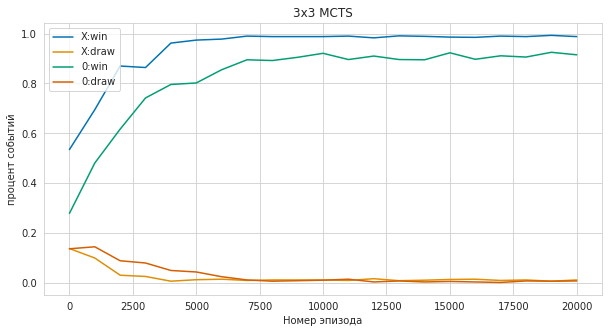

In [ ]:
%%time
np.random.seed(42)
env = TicTacToe(3,3,3)
tree = MCTSTree(env,pi_random,20)
pi = MCTSStrategy(tree,tree,pi_random)
reward_mcts = reward_by_games(env,pi,pi_random)
print("V(mcts X)=",reward_mcts, "pi_mcts=",pi)
N=20000
print_step = 1000
steps = []
episode_stat = {"X:win":[],"X:draw":[],"0:win":[],"0:draw":[],"X:step":[]}

for i in range(N+1):
    tree.step()
    if i%print_step==0:
        print(i,end=" ")
        rX = reward_by_games(env,pi,pi_random)
        r0 = reward_by_games(env,pi_random,pi)
        episode_stat["X:win"].append(rX["X"])
        episode_stat["X:draw"].append(rX["-"])
        episode_stat["X:step"].append(rX["mean_step"])
        episode_stat["0:win"].append(r0["0"])
        episode_stat["0:draw"].append(r0["-"])                                                                            
        steps.append(i)
print()

rX = reward_by_games(env,pi,pi_random)
print("V(mcts X)=",rX, "pi_mcts=",pi)
r0 = reward_by_games(env,pi_random,pi)
print("V(mcts 0)=",r0, "pi_mcts=",pi)
plot_durations("3x3 MCTS",steps,episode_stat,["X:step"])

### 4x4

V(mcts X)= {'X': 0.33, '0': 0.274, '-': 0.396, 'fail': 0.0, 'mean_step': 14.578} pi_mcts= [MCTS:1]
0 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 V(mcts X)= {'X': 0.718, '0': 0.12, '-': 0.162, 'fail': 0.0, 'mean_step': 10.832} pi_mcts= [MCTS:991629]
V(mcts 0)= {'X': 0.196, '0': 0.565, '-': 0.239, 'fail': 0.0, 'mean_step': 13.456} pi_mcts= [MCTS:991629]
CPU times: user 24min 3s, sys: 3.6 s, total: 24min 6s
Wall time: 24min 8s


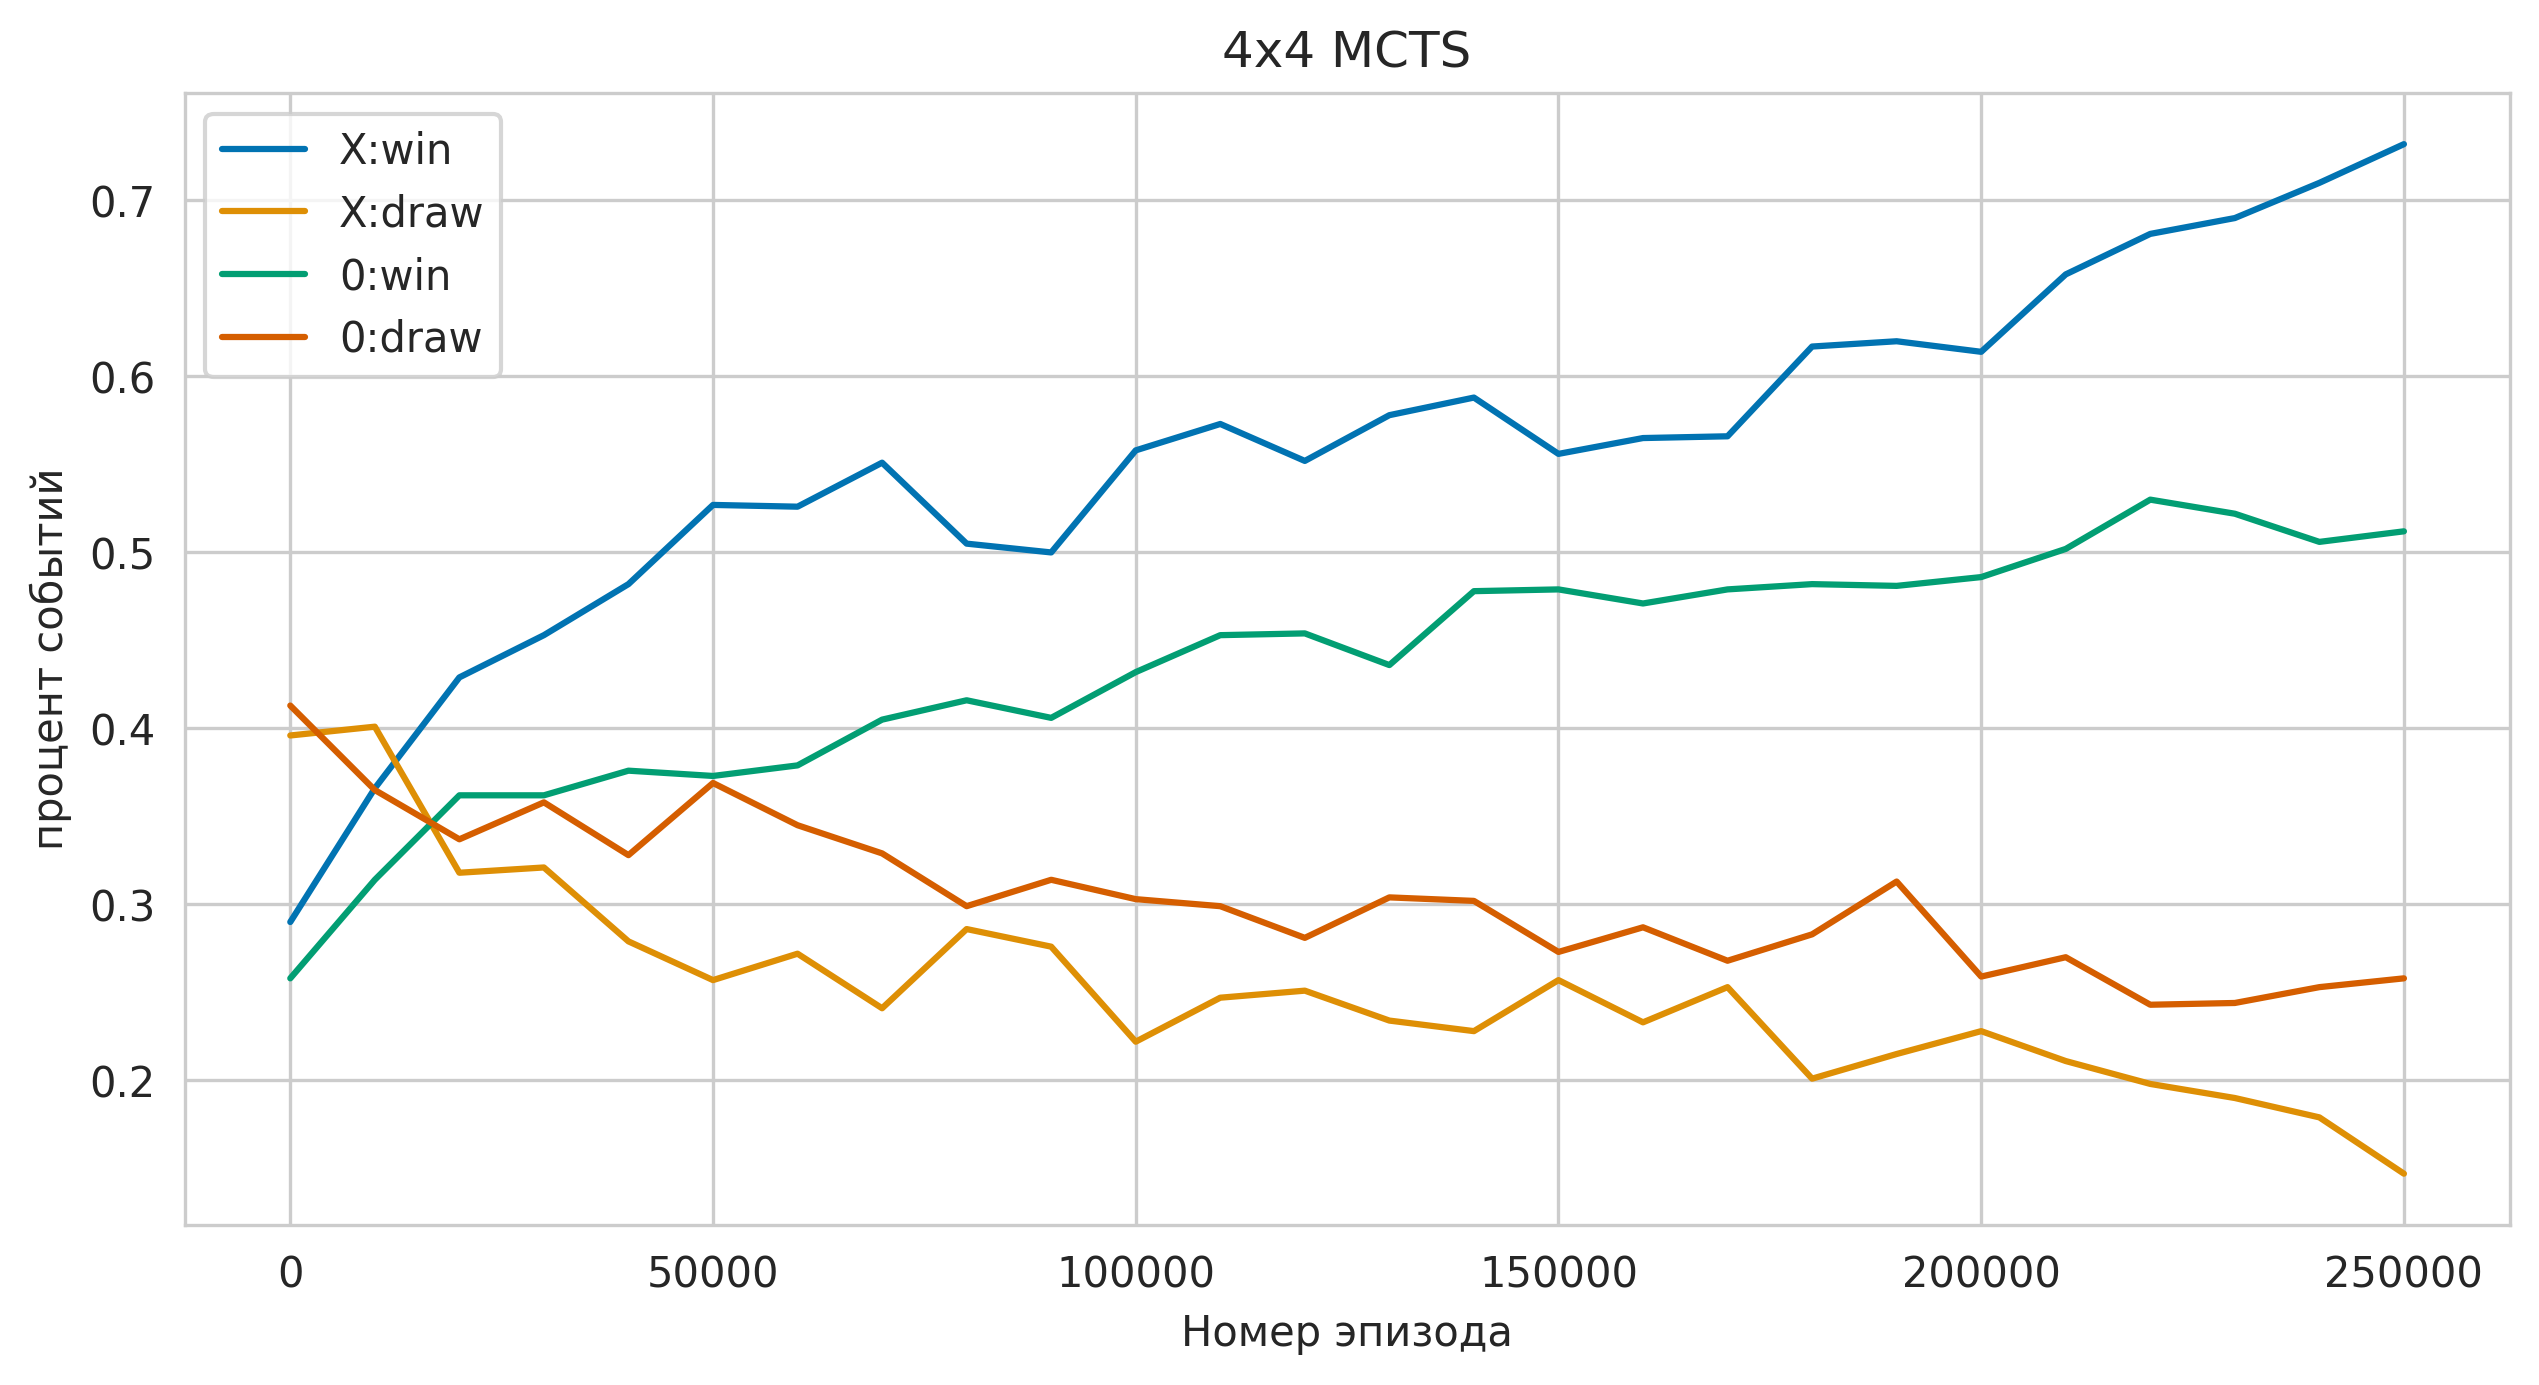

In [ ]:
%%time
np.random.seed(42)
env = TicTacToe(4,4,4)
tree = MCTSTree(env,pi_random,20)
pi = MCTSStrategy(tree,tree,pi_random)
reward_mcts = reward_by_games(env,pi,pi_random)
print("V(mcts X)=",reward_mcts, "pi_mcts=",pi)
N=250000
print_step = 10000
steps = []
episode_stat = {"X:win":[],"X:draw":[],"0:win":[],"0:draw":[],"X:step":[]}

for i in range(N+1):
    tree.step()
    if i%print_step==0:
        print(i,end=" ")
        rX = reward_by_games(env,pi,pi_random)
        r0 = reward_by_games(env,pi_random,pi)
        episode_stat["X:win"].append(rX["X"])
        episode_stat["X:draw"].append(rX["-"])
        episode_stat["X:step"].append(rX["mean_step"])
        episode_stat["0:win"].append(r0["0"])
        episode_stat["0:draw"].append(r0["-"])                                                                            
        steps.append(i)

rX = reward_by_games(env,pi,pi_random)
print("V(mcts X)=",rX, "pi_mcts=",pi)
r0 = reward_by_games(env,pi_random,pi)
print("V(mcts 0)=",r0, "pi_mcts=",pi)
plot_durations("4x4 MCTS",steps,episode_stat,["X:step"])